In [194]:
"""Preprocess text extracted from scholarly articles into keyphrase candidates.       

The expected input is a list of text extracted from scholarly papers published in Russian from
the dialog conference. The first step is to remove the reference section and any unusually short
paragraphs. Then, parenthesized and bracketed text are removed, as well as any words that happen
to be cut off at a new page boundary.

The text is then tokenized using the preprocessing and tokenization technique developed by 
WebVectores [Kutuzov 2017]. At this point, documents in the corpus are transformed into
lists of tokens corresponding to the paragraphs in the document. Tokens are unigrams of lowercased
lemmas or punctuation marks.

Each document is then broken into sentences, and n-grams are added. This results in each document
being transformed into a list of sentence tokens, which may be unigrams, bigrams, or trigrams.
Finally, the sentence tokens are filtered to remove any unusually short or long tokens and stop
words. The document is flattened, resulting in it being transformed into a list of keyphrase 
candidate tokens.

Typical usage example:

    file_names = get_file_names("../data/raw_txt/2010/ru", ".txt")
    corpus = [get_text(name) for name in file_names]
    corpus = ScholarlyPreprocessor.preprocess(corpus, file_names)
"""

# Reset the kernel (ipython magic command)
%reset -f

## How to load the preprocessed data

In [196]:
from pathlib import Path
from topic_modeling import TopicModeler


# Load the preprocessed corpus
year_range = range(2006, 2021)
input_dir = str(Path("../data/preprocessed").resolve())
corpus = TopicModeler.load_corpus(year_range, input_dir)

# Create an id-token mapping for the vocabulary
dictionary = TopicModeler.create_dictionary(corpus)
print("Dictionary:\n", dictionary)

# Create the document-token frequency (Bag-of-Words) representation of the corpus
bow_corpus = TopicModeler.create_bow(corpus, dictionary)
print("-"*50, "\n\nBag-of-Words, first 20 tokens in the first document:\n", bow_corpus[0][:20])

2020-07-19 14:32:18,931 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\data\preprocessed\2006.pickle
2020-07-19 14:32:18,965 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\data\preprocessed\2007.pickle
2020-07-19 14:32:18,995 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\data\preprocessed\2008.pickle
2020-07-19 14:32:19,021 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\data\preprocessed\2009.pickle
2020-07-19 14:32:19,044 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\data\preprocessed\2010.pickle
2020-07-19 14:32:19,072 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\data\preprocessed\2011.pickle
2020-07-19 14:32:19,086 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\d

Dictionary:
 Dictionary(11562 unique tokens: ['1-е', 'автоматический', 'актер', 'актуализация', 'анализ']...)
-------------------------------------------------- 

Bag-of-Words, first 20 tokens in the first document:
 [(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 2), (9, 2), (10, 2), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1)]


## Optimize the number of latent topics

In [ ]:
# Note: This will not work through jupyter notebook one Windows due to the multiprocessing
# module used for calculating Cv Coherence. Run these commands in a python shell.

from pathlib import Path
from topic_modeling import optimize_num_topics, TopicModeler


# Parameters
year_range = range(2000, 2021)
input_dir = str(Path("../data/").resolve())
target = str(Path("../data/LDA/num_topics").resolve())
repetitions = 3
no_above = .75
no_below = 2
candidate_num_topics = range(2, 11)

corpus = TopicModeler.load_corpus(year_range, input_dir)
dictionary = TopicModeler.create_dictionary(corpus, no_below=no_below, no_above=no_above)
bow_corpus = TopicModeler.create_bow(corpus, dictionary)
optimize_num_topics(candidate_num_topics, corpus, dictionary, bow_corpus, 
                    target, repetitions=repetitions)

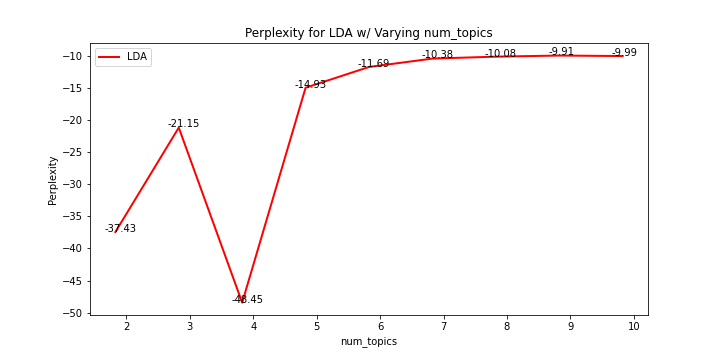

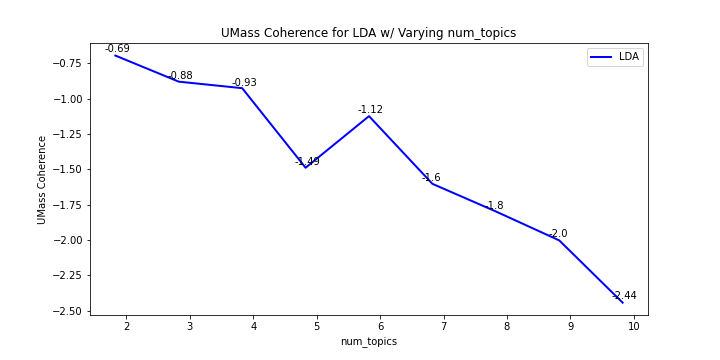

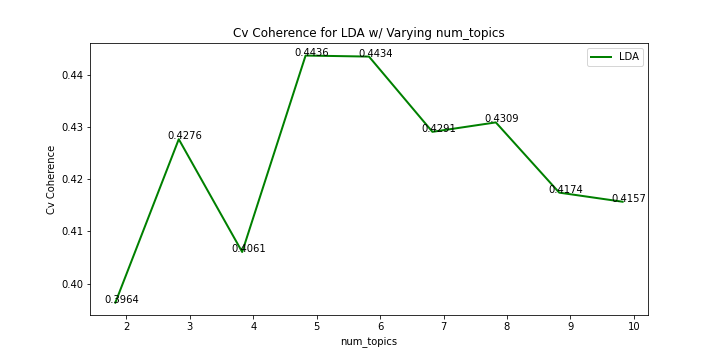

In [78]:
from IPython.display import Image
from pathlib import Path


# Show the results of optimizing num_topics
input_dir = str(Path("../data/LDA/num_topics/").resolve())
display(Image(str(Path(input_dir, "num_topics-perplexity.png"))))
display(Image(str(Path(input_dir, "num_topics-coherence_umass.png"))))
display(Image(str(Path(input_dir, "num_topics-coherence_cv.png"))))

## Optimize no_above

In [ ]:
# Note: This will not work through jupyter notebook one Windows due to the multiprocessing
# module used for calculating Cv Coherence. Run these commands in a python shell.

from pathlib import Path
from topic_modeling import optimize_no_above, TopicModeler


# Parameters
year_range = range(2000, 2021)
input_dir = str(Path("../data/").resolve())
target = str(Path("../data/LDA/no_above").resolve())
repetitions = 3
num_topics = 6
no_below = 2
candidate_no_above= [i/100 for i in range(50, 101, 5)]

corpus = TopicModeler.load_corpus(year_range, input_dir)
optimize_no_above(candidate_no_above, corpus, target,
                  no_below=no_below, repetitions=repetitions, num_topics=num_topics)

In [ ]:
from IPython.display import Image
from pathlib import Path

# Show the results of optimizing no_above
input_dir = str(Path("../data/LDA/no_above/").resolve())
display(Image(str(Path(input_dir, "no_above-perplexity.png"))))
display(Image(str(Path(input_dir, "no_above-coherence_umass.png"))))
display(Image(str(Path(input_dir, "no_above-coherence_cv.png"))))

## Optimize no_below

In [ ]:
# Note: This will not work through jupyter notebook one Windows due to the multiprocessing
# module used for calculating Cv Coherence. Run these commands in a python shell.

from pathlib import Path
from topic_modeling import optimize_no_below, TopicModeler


# Parameters
year_range = range(2000, 2021)
input_dir = str(Path("../data/").resolve())
target = str(Path("../data/LDA/no_below").resolve())
repetitions = 3
num_topics = 6
no_above = .75
candidate_no_below= [i for i in range(1, 11)]

corpus = TopicModeler.load_corpus(year_range, input_dir)
optimize_no_below(candidate_no_below, corpus, target,
                  no_above=no_above, repetitions=repetitions, num_topics=num_topics)

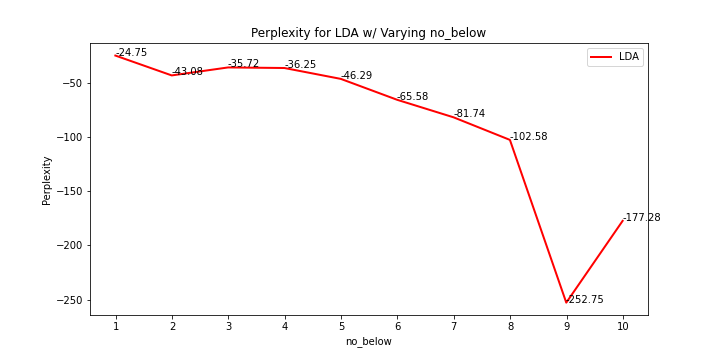

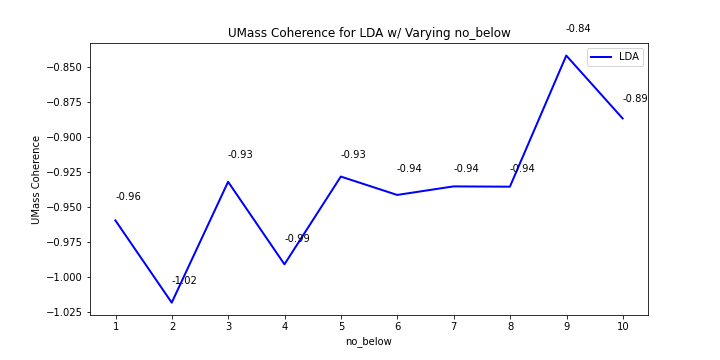

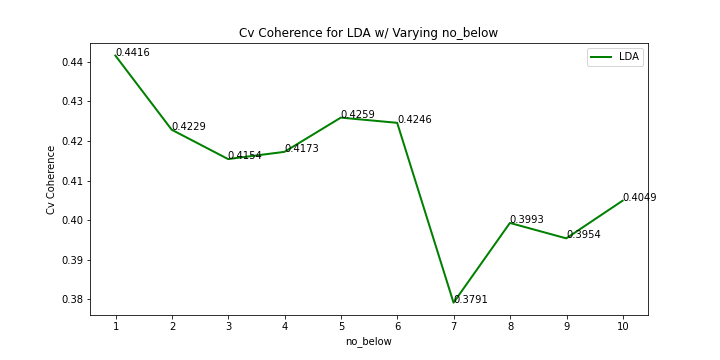

In [80]:
from IPython.display import Image
from pathlib import Path

# Show the results of optimizing no_below
input_dir = str(Path("../data/LDA/no_below/").resolve())
display(Image(str(Path(input_dir, "no_below-perplexity.png"))))
display(Image(str(Path(input_dir, "no_below-coherence_umass.png"))))
display(Image(str(Path(input_dir, "no_below-coherence_cv.png"))))

## Run LDA with the optimized parameters

In [19]:
from helpers import get_file_names
from pathlib import Path
from topic_modeling import TopicModeler

import logging
import os
import pickle

num_topics = 6
no_above = .75
no_below = 1
repetitions = 5
num_articles = 5
num_words = 10

target = str(Path("../data/LDA/final").resolve())
if not os.path.exists(target):
    os.makedirs(target)

# Load the preprocessed corpus
year_range = range(2000, 2021)
input_dir = str(Path("../data/preprocessed").resolve())
entire_corpus = {}
cur_corpus = {}
for year in year_range:
    input_file = Path(input_dir, str(year) + ".pickle")
    cur_corpus = []
    with open(input_file, "rb") as file:
        cur_corpus = pickle.load(file)
    file_names = get_file_names("../data/raw_txt/" + str(year) + "/ru", ".txt")
    file_names = [os.path.split(name)[1][:20] for name in file_names]
    
    for doc_id, doc in enumerate(cur_corpus):
        key = str(year) + "_" + file_names[doc_id]
        entire_corpus[key] = doc
    
    # Create and save the LDA model for each year
    dictionary = TopicModeler.create_dictionary(cur_corpus, no_below=no_below, no_above=no_above)
    bow_corpus = TopicModeler.create_bow(cur_corpus, dictionary)
    
    # Get the best model of some repetitions
    best_coherence = -1
    for i in range(repetitions):
        print("Repetition [{}/{}] for {}".format(i+1, repetitions, year), end=" ")
        lda_model = TopicModeler.train_lda(bow_corpus, dictionary, num_topics=num_topics)
        cur_coherence = TopicModeler.get_coherence_cv(lda_model, cur_corpus, dictionary)
        if (cur_coherence > best_coherence):
            best_coherence = cur_coherence
            lda_model.save(str(Path(target, str(year)+ ".gensim")))
        print("Coherence = {} (best: {})".format(cur_coherence, best_coherence))
    lda_model = LdaModel.load(str(Path(target, str(year) + ".gensim")))
    
    # Get the num_articles most related articles for each topic
    topic_probs = {i: [] for i in range(num_topics)}
    top_articles = []
    for doc_id, doc in enumerate(cur_corpus):
        key = str(year) + "_" + file_names[doc_id]
        topic_distribution = lda_model[lda_model.id2word.doc2bow(doc)]

        for topic_id, probability in topic_distribution:
            topic_probs[topic_id].append((key, probability))
    for topic_id, doc_probs in topic_probs.items():
        doc_probs = sorted(doc_probs, key = lambda x: x[1], reverse = True)
        top_articles.append([prob for prob in doc_probs[:num_articles]]) 
    
    # Print the learned topics and the top associated keyphrases
    print("Topics for", str(year) + ":")
    TopicModeler.print_topics(lda_model, num_words=num_words, top_articles=top_articles)
    cur_corpus = None

# Get keywords for the entire corpus
dictionary = TopicModeler.create_dictionary(entire_corpus.values(), no_below=no_below, no_above=no_above)
bow_corpus = TopicModeler.create_bow(entire_corpus.values(), dictionary)

# Get the best model of some repetitions
best_coherence = -1
for i in range(repetitions):
    print("Repetition [{}/{}] for entire corpus".format(i+1, repetitions), end=" ")
    lda_model = TopicModeler.train_lda(bow_corpus, dictionary, num_topics=num_topics)
    cur_coherence = TopicModeler.get_coherence_cv(lda_model, entire_corpus.values(), dictionary)
    if (cur_coherence > best_coherence):
        best_coherence = cur_coherence
        lda_model.save(str(Path(target, "all.gensim")))
    print("Coherence = {} (best: {})".format(cur_coherence, best_coherence))
lda_model = LdaModel.load(str(Path(target, "all.gensim")))

topic_probs = {i: [] for i in range(num_topics)}
top_articles = []
for doc_id, doc in entire_corpus.items():
    topic_distribution = lda_model[lda_model.id2word.doc2bow(doc)]
    for topic_id, probability in topic_distribution:
        topic_probs[topic_id].append((doc_id, probability))
for topic_id, doc_probs in topic_probs.items():
    doc_probs = sorted(doc_probs, key = lambda x: x[1], reverse = True)
    top_articles.append([prob for prob in doc_probs[:num_articles]]) 

print("Topics for entire dialog corpus:")
TopicModeler.print_topics(lda_model, num_words=num_words, top_articles=top_articles)

Repetition [1/5] for 2000 Coherence = 0.344060516903074 (best: 0.344060516903074)
Repetition [2/5] for 2000 Coherence = 0.3628998502985666 (best: 0.3628998502985666)
Repetition [3/5] for 2000 Coherence = 0.3599844394683462 (best: 0.3628998502985666)
Repetition [4/5] for 2000 Coherence = 0.36406869218432103 (best: 0.36406869218432103)
Repetition [5/5] for 2000 Coherence = 0.39921517347298074 (best: 0.39921517347298074)
Topics for 2000:


,Topic #,Top keywords,Most related articles
0,1,"шаман, мнаш число, берег, категория, шаманский, множественный число, квантор, тазовский, баишенский, едалее число","[2000_автоматический-морфо - 62.64], [2000_об-использовании-экс - 44.35], [2000_наречия-группы-сразу - 40.22], [2000_шаманская-лексика-в- - 34.85], [2000_фигура-наблюдателя-в - 31.64]"
1,2,"синтез, знак, наблюдение, обращаться, эмотикон, стимул, алфавит, сознание, чужой, зона","[2000_закономерности-постр - 55.99], [2000_о-высоте-гласных-в-р - 55.85], [2000_географические-назва - 48.08], [2000_генерация-тонального - 45.20], [2000_еще-раз-к-строгому-о - 41.33]"
2,3,"значение, семантический, узел, действие, валентность, предмет, наблюдатель, семантика, край, обозначать","[2000_бьют-ли-часы-и-фонта - 78.51], [2000_об-источниках-полисе - 59.59], [2000_семантические-особен - 59.52], [2000_восстанавливаемость- - 59.48], [2000_нетрадиционные-значе - 59.44]"
3,4,"идиома, адресат, реплика, поведение, сообщать, акт, противопоставление, подросток, приезжать, дискурсивный","[2000_клишированные-формул - 56.87], [2000_идиоматические-едини - 54.05], [2000_принцип-цивилизованн - 53.29], [2000_речевые-формулы-в-ди - 53.14], [2000_к-типологии-ложных-у - 44.40]"
4,5,"представлять, информация, правило, значение, образ, описание, основа, элемент, пример, структура","[2000_вариант-системы-расп - 99.88], [2000_алгоритмы-cегментаци - 99.71], [2000_abbyy-retrieval-morp - 99.60], [2000_численное-моделирова - 97.29], [2000_подходы-к-решению-пр - 97.06]"
5,6,"указательный, референт, эпизод, точка референция, дискурс, концептуализация, референты, анафорический, данный референт, референция","[2000_текстовая-анафора-со - 42.33], [2000_к-проблеме-понимания - 40.90], [2000_digitall-writing-e-s - 38.97], [2000_некоторые-проблемы-с - 34.55], [2000_отражение-особенност - 32.82]"


Repetition [1/5] for 2001 Coherence = 0.34300095927988067 (best: 0.34300095927988067)
Repetition [2/5] for 2001 Coherence = 0.35599757548298494 (best: 0.35599757548298494)
Repetition [3/5] for 2001 Coherence = 0.3247790522102279 (best: 0.35599757548298494)
Repetition [4/5] for 2001 Coherence = 0.35877583694144294 (best: 0.35877583694144294)
Repetition [5/5] for 2001 Coherence = 0.4523055900568742 (best: 0.4523055900568742)
Topics for 2001:


,Topic #,Top keywords,Most related articles
0,1,"вербальный, стратегия, знак, компонент, информация, устный, лингвистический, невербальный, спонтанный, селькупский","[2001_семиосфера-электронн - 57.81], [2001_семиотические-пробле - 56.65], [2001_стратегии-коммуникат - 51.99], [2001_лингвистическое-обес - 49.84], [2001_о-постановке-проблем - 48.98]"
1,2,"документ, понятие, поиск, информация, пользователь, основа, знание, необходимый, задача, база","[2001_лемматизация-слов-ру - 94.59], [2001_обзор-методов-класте - 86.01], [2001_создание-базы-данных - 85.92], [2001_возможный-подход-к-у - 84.89], [2001_система-представлени - 84.86]"
2,3,"нес, совотреть, прокармливать, видовой связь, совей, императив, видовой пар, законный, обязательный имперфективация, опаздывать","[2001_лексика-со-значением - 54.76], [2001_типы-видовой-связи.t - 46.64], [2001_опыт-построения-одно - 42.34], [2001_политический-анекдот - 41.14], [2001_о-влиянии-типов-видо - 35.93]"
3,4,"идиома, рисковать, таксон, страх, рискнуть, поступок, эмоция, метафорический, сходный, след","[2001_обозначение-симптомо - 54.95], [2001_деривационный-подход - 53.69], [2001_метафорические-модел - 53.69], [2001_проблема-репрезентат - 48.44], [2001_отражение-неоднородн - 48.44]"
4,5,"сигнал, вычет, импульс, пауза, аллофон, кодек, квантификатор, отсчет, колебание, задержка","[2001_громкость-разностных - 49.27], [2001_об-одном-подходе-к-с - 41.38], [2001_синтезатор-речи-по-т - 37.65], [2001_система-речевой-связ - 36.69], [2001_семантика-и-прагмати - 33.07]"
5,6,"значение, тип, разный, семантический, связывать, пример, описывать, рассматривать, действие, класс","[2001_cтепень-и-количество - 99.86], [2001_базовые-категории-фо - 99.58], [2001_русские-прилагательн - 97.01], [2001_существует-ли-симмет - 95.14], [2001_анализ-аргументативн - 94.42]"


Repetition [1/5] for 2002 Coherence = 0.38472371368617275 (best: 0.38472371368617275)
Repetition [2/5] for 2002 Coherence = 0.3624315645163289 (best: 0.38472371368617275)
Repetition [3/5] for 2002 Coherence = 0.3882556184823598 (best: 0.3882556184823598)
Repetition [4/5] for 2002 Coherence = 0.42533990234438396 (best: 0.42533990234438396)
Repetition [5/5] for 2002 Coherence = 0.36672316698782964 (best: 0.42533990234438396)
Topics for 2002:


,Topic #,Top keywords,Most related articles
0,1,"понятие, знание, тезаурус, вербальный, область, основа, графический, онтология, научный, знак","[2002_семантический-поиск- - 79.40], [2002_конвейерное-моделиро - 76.32], [2002_традиционные-газетти - 74.25], [2002_введение-в-теорию-по - 73.89], [2002_автоматическое-попол - 72.71]"
1,2,"пользователь, морфологический, задача, информация, основа, ресурс, транскрипция, модуль, база, список","[2002_on-line-интерфейс-на - 68.05], [2002_разработка-формализм - 58.37], [2002_технология-представл - 52.35], [2002_синтезатор-татарской - 51.33], [2002_к-разработке-татарск - 51.04]"
2,3,"значение, тип, жанр, правило, процесс, информация, описывать, структура, общение, разный","[2002_вычислительная-модел - 99.85], [2002_построение-расширени - 99.63], [2002_on-the-interactive-e - 99.63], [2002_автоматическая-генер - 99.61], [2002_аналитические-констр - 99.24]"
3,4,"жестовый, жестовый язык, персонаж, самолюбие, гордость, достоинство, синоним, редупликация, императив, чутье","[2002_анекдоты-об-армянско - 50.28], [2002_каждая-несчастливая- - 49.87], [2002_достоинство-гордость - 49.68], [2002_некнижные-синтаксиче - 49.15], [2002_есть-ли-орган-для-ше - 41.83]"
4,5,"флексия, испытуемый, кличка, экспериментальный, звук, животное, мозг, гласный, электрод, карточка","[2002_кто-такой-снусмумрик - 47.76], [2002_синтаксическая-коорд - 46.49], [2002_к-понятию-симметричн - 42.04], [2002_индивидуальный-стиль - 39.92], [2002_метод-вызванных-поте - 36.16]"
5,6,"поведение, языковой личность, сознание, острый, радость, различие, собеседник, событие, коммуникативный, личность","[2002_боль-и-части-человеч - 70.54], [2002_русские-и-арабские-с - 63.17], [2002_грамматические-помет - 61.54], [2002_новые-материалы-к-ас - 58.71], [2002_прилагательные-функц - 57.93]"


Repetition [1/5] for 2003 Coherence = 0.3663379273369843 (best: 0.3663379273369843)
Repetition [2/5] for 2003 Coherence = 0.3411029123435189 (best: 0.3663379273369843)
Repetition [3/5] for 2003 Coherence = 0.3705554568453553 (best: 0.3705554568453553)
Repetition [4/5] for 2003 Coherence = 0.37170876828662397 (best: 0.37170876828662397)
Repetition [5/5] for 2003 Coherence = 0.39085541358508874 (best: 0.39085541358508874)
Topics for 2003:


,Topic #,Top keywords,Most related articles
0,1,"тип, основа, предикат, значение, описывать, основа настоящий, синтаксический, грамматика, суффикс, глагольный","[2003_фрагмент-модели-лито - 68.09], [2003_еще-раз-о-соотношени - 67.43], [2003_проблема-кореференци - 64.48], [2003_актуальные-значения- - 64.12], [2003_лексико-функциональн - 62.79]"
1,2,"значение, связывать, действие, тип, понимание, цель, функция, выделять, свойство, называть","[2003_what-communists-know - 98.65], [2003_а-ты-сам-то-как-дума - 94.06], [2003_алгоритмы-сегментаци - 91.50], [2003_зияния-в-русском-язы - 86.35], [2003_об-определении-функц - 85.70]"
2,3,"сонет, державин, определительный композит, нс1, композит, караок, ассоциация, опорный компонент, секс, ломоносов","[2003_полосатые-васьки-и-з - 56.51], [2003_новые-возможности-по - 52.48], [2003_дни-недели-в-различн - 48.28], [2003_поэзия-интертекста-и - 44.62], [2003_несклоняемые-существ - 42.44]"
3,4,"информация, правило, структура, документ, основа, поиск, запрос, задача, описание, определять","[2003_автоматизация-процес - 97.35], [2003_адаптивный-лингвисти - 94.04], [2003_алгоритм-формировани - 93.01], [2003_проблемы-разработки- - 85.27], [2003_интернетинтранет-сис - 83.34]"
4,5,"анекдот, пушкин, эмоция, встречаться, идиома, целый, отрицание, тип, устный, противопоставление","[2003_парадоксы-стилистиче - 66.11], [2003_фоновые-знания-в-рус - 63.51], [2003_глагольные-времена-в - 60.62], [2003_внутренняя-форма-иди - 56.09], [2003_большие-проблемы-мал - 51.05]"
5,6,"кошка, подзначение, кличка, д-сценария, стихотворение, адресат, зависимый, воздействие, кот, критический элемент","[2003_когнитивные-аспекты- - 43.85], [2003_глаголы-перемещения- - 43.30], [2003_приименное-зависимое - 38.84], [2003_дейктическая-характе - 35.02], [2003_описание-речевого-во - 34.30]"


Repetition [1/5] for 2004 Coherence = 0.36089852173994624 (best: 0.36089852173994624)
Repetition [2/5] for 2004 Coherence = 0.36023374850731393 (best: 0.36089852173994624)
Repetition [3/5] for 2004 Coherence = 0.31356098203468336 (best: 0.36089852173994624)
Repetition [4/5] for 2004 Coherence = 0.3685014738985508 (best: 0.3685014738985508)
Repetition [5/5] for 2004 Coherence = 0.4008223422888391 (best: 0.4008223422888391)
Topics for 2004:


,Topic #,Top keywords,Most related articles
0,1,"запрос, семантический сеть, сайт, дорожка, обучение, страница, агент, ромип, концепция, сущ","[2004_приставочная-парадиг - 46.41], [2004_автоматические-опера - 39.44], [2004_перевод-на-основе-ба - 39.20], [2004_о-представлении-форм - 34.57], [2004_некоторые-подходы-к- - 31.17]"
1,2,"селькупский, междометие, винаш пункт, древнерусский, уральский язык, сообщение, изменение, селькупский язык, становиться, рекламный","[2004_об-общих-значениях-г - 59.39], [2004_6-способов-косвенног - 51.52], [2004_о-фонологических-еди - 46.41], [2004_междометия-догадки-в - 43.97], [2004_еhomo-два-в-одном.tx - 41.99]"
2,3,"спам, мнута ч, письмо, значительный, этикет, серия, неопределенный, рождение, поведение, сказуемое","[2004_анекдоты-о-животных- - 73.08], [2004_понятия-деликатности - 64.15], [2004_вычисление-значимой- - 60.84], [2004_уменьшительные-имена - 56.85], [2004_двойной-генитив-в-ру - 54.51]"
3,4,"информация, структура, позволять, основа, возможность, использование, описывать, функция, задача, качество","[2004_авиаонтология-анализ - 99.81], [2004_анализ-связанных-объ - 99.75], [2004_автоматическое-выдел - 98.46], [2004_автоматическая-генер - 97.27], [2004_разработка-прикладны - 94.95]"
4,5,"значение, отрицание, вовремя, разный, действие, снимать утвердительности, компонент, предикат, подобный, толкование","[2004_кванторы-со-значение - 83.27], [2004_эффект-снятой-утверд - 78.57], [2004_yandex-как-лексикогр - 78.52], [2004_о-классификации-прос - 78.07], [2004_доползем-ли-долетим- - 75.86]"
5,6,"резко, референциальный, килограмм, фактор, референт, просодический, нарратив, безударный, антецедент, повторный упоминание","[2004_к-формированию-акуст - 45.86], [2004_проблема-номинации-п - 43.05], [2004_персональные-особенн - 41.47], [2004_ситуационная-анафора - 40.59], [2004_наречия-в-системе-ле - 40.36]"


Repetition [1/5] for 2005 Coherence = 0.3991038305508668 (best: 0.3991038305508668)
Repetition [2/5] for 2005 Coherence = 0.3867157369884528 (best: 0.3991038305508668)
Repetition [3/5] for 2005 Coherence = 0.38123942124237226 (best: 0.3991038305508668)
Repetition [4/5] for 2005 Coherence = 0.3931583297863248 (best: 0.3991038305508668)
Repetition [5/5] for 2005 Coherence = 0.37771305219664186 (best: 0.3991038305508668)
Topics for 2005:


,Topic #,Top keywords,Most related articles
0,1,"знак, средний, фраза, фонема, поведение, звук, ожидание, слог, результат, сигнал","[2005_экспериментальное-ис - 70.40], [2005_аллитерация-в-прозаи - 66.20], [2005_реализация-межязыков - 64.24], [2005_семиотическая-лингви - 62.56], [2005_ларингализация-в-оце - 58.56]"
1,2,"коррекция, финский язык, омоним, служебный, переводчик, лексический единица, параллельный, вдоль, реферат, н-лат","[2005_коррекция-сбоев-в-ус - 56.13], [2005_обнаружение-и-исправ - 45.43], [2005_автоматическое-постр - 39.94], [2005_метод-синтаксическог - 36.81], [2005_корпус-параллельных- - 32.19]"
2,3,"семантический, указывать, функция, разный, оценка, выражать, предлог, синтаксический, называть, интерпретация","[2005_зависит-ли-синтаксич - 88.11], [2005_периферийные-показат - 87.83], [2005_к-вопросу-о-составе- - 84.88], [2005_семантическая-специф - 84.11], [2005_оценочные-предикаты- - 83.40]"
3,4,"документ, запрос, информация, фрагмент, результат, поиск, алгоритм, правило, задача, основа","[2005_адаптивный-интерфейс - 96.00], [2005_аналитическая-информ - 93.08], [2005_автоматическая-актуа - 91.58], [2005_подход-к-автоматизац - 88.25], [2005_семиотический-анализ - 85.58]"
4,5,"метафора, констелляция, коррупция, бывший, адресат, наблюдатель, статус, посессор, 1-е, сочетаться","[2005_омонимия-и-синонимия - 57.33], [2005_валентные-свойства-р - 54.12], [2005_феномен-коррупции-в- - 51.39], [2005_верификация-словарны - 50.93], [2005_невербальный-контрол - 48.15]"
5,6,"анекдот, обоюдный, императив, ладно, этикет, совместный общий, спартак, коммуникация, армянский, оппозиция","[2005_о-роли-неважности-в- - 51.75], [2005_русский-анекдот-в-дв - 49.96], [2005_собственные-наименов - 45.72], [2005_логико-психологическ - 42.08], [2005_конструкции-измерени - 39.01]"


Repetition [1/5] for 2006 Coherence = 0.35022311761547337 (best: 0.35022311761547337)
Repetition [2/5] for 2006 Coherence = 0.36728735704583665 (best: 0.36728735704583665)
Repetition [3/5] for 2006 Coherence = 0.3995388665727775 (best: 0.3995388665727775)
Repetition [4/5] for 2006 Coherence = 0.36620126652292795 (best: 0.3995388665727775)
Repetition [5/5] for 2006 Coherence = 0.40027114697928806 (best: 0.40027114697928806)
Topics for 2006:


,Topic #,Top keywords,Most related articles
0,1,"проблема, разный, семантический, сравнение, описывать, длина, приводить, оказываться, связывать, свойство","[2006_два-какой-в-русском- - 97.50], [2006_метод-контекстного-р - 96.39], [2006_автоматизация-формир - 95.94], [2006_немецкие-сложные-при - 95.63], [2006_дистрибуция-русских- - 92.94]"
1,2,"клон, аллофон, база, правдоподобие, оценка, диктор ближний, согласный, естественный, твердый, гласный","[2006_экспериментальная-оц - 65.71], [2006_фонетико-акустическа - 62.40], [2006_анализ-параметров-ре - 37.80], [2006_мелодические-признак - 35.66], [2006_лексико-грамматическ - 34.95]"
2,3,"судьба, событие, испытуемый, сужден, склонять, происходить, предопределение, поезд, экспериментальный, скорость","[2006_отношения-производно - 50.90], [2006_автоматическая-генер - 48.43], [2006_лабильность-в-русско - 45.34], [2006_о-лексических-маркер - 41.32], [2006_анализ-речевых-ошибо - 37.94]"
3,4,"добрый, высота, намек, пословица, ладонь, параметрический, обхват, палец, охапка, размер предмет","[2006_об-ушедшем-языковом- - 67.06], [2006_интертекстуальные-фр - 58.20], [2006_о-новом-подходе-к-кл - 49.68], [2006_идиомы-семантическог - 45.39], [2006_намек-как-способ-кос - 41.82]"
4,5,"стратегия, отрицание, общение, сочинять, сегмент, структура, знак, отрицательный, слог, позиция","[2006_база-данных-интонаци - 69.83], [2006_интонация-связного-т - 66.19], [2006_грамматика-диалога-т - 65.43], [2006_рекурсивность-и-прое - 62.51], [2006_сопоставительный-ана - 57.51]"
5,6,"документ, алгоритм, онтология, метод, знание, набор, поиск, связь, база, рубрика","[2006_автоматизированное-п - 84.00], [2006_кластеризация-докуме - 76.91], [2006_подход-к-построению- - 72.62], [2006_полидоменные-модели- - 69.72], [2006_классификационная-ср - 66.64]"


Repetition [1/5] for 2007 Coherence = 0.37353607445883386 (best: 0.37353607445883386)
Repetition [2/5] for 2007 Coherence = 0.35930044909607123 (best: 0.37353607445883386)
Repetition [3/5] for 2007 Coherence = 0.38115096334902177 (best: 0.38115096334902177)
Repetition [4/5] for 2007 Coherence = 0.37839594886275757 (best: 0.38115096334902177)
Repetition [5/5] for 2007 Coherence = 0.3194030887654708 (best: 0.38115096334902177)
Topics for 2007:


,Topic #,Top keywords,Most related articles
0,1,"сайт, клиент, анекдот, мысль, раздел, боян, аргументация, острота, коммуникация, доказательство","[2007_двойная-семантика-по - 58.51], [2007_постсоветские-русски - 49.63], [2007_давление-дискурса-и- - 48.29], [2007_язык-корпоративных-с - 47.16], [2007_мыслию-по-древу-семи - 46.99]"
1,2,"использование, интернет, оценка, основа, задача, база, информация, создание, количество, элемент","[2007_автоматическое-распо - 96.32], [2007_автоматическая-класс - 95.81], [2007_основные-компоненты- - 80.61], [2007_выявление-новых-собы - 79.02], [2007_словарная-картотека- - 77.68]"
2,3,"диктор, эксперт, сегмент, испытуемый, аллофон, аудитивный впечатление, слог, фонетический, проводить, сигнал","[2007_правила-разметки-реч - 62.30], [2007_технология-компьютер - 56.96], [2007_экспертный-метод-диа - 56.95], [2007_алгоритмы-синтеза-пр - 56.90], [2007_методика-идентификац - 54.66]"
3,4,"указывать, разный, признак, адресат, употреблять, семантика, показывать, называть, фраза, компонент","[2007_в-поисках-наблюдател - 99.78], [2007_членение-пространств - 90.44], [2007_русский-угрозатив-и- - 90.42], [2007_база-данных-интонаци - 89.22], [2007_уже-и-уж-вариативнос - 87.85]"
4,5,"понятие, синтаксический, алгоритм, правило, структура, задача, зависеть, отрезок, связь, функция","[2007_алгоритм-синтаксичес - 99.23], [2007_экспериментальная-ре - 86.69], [2007_построение-и-использ - 80.62], [2007_автоматическое-извле - 75.92], [2007_опыт-латышско-русско - 67.51]"
5,6,"множественный число, сочетание, недавний, давний, знание, предикат, вчерашний, периферия, круглый, временный","[2007_каталог-семантически - 58.54], [2007_полисемия-временных- - 55.63], [2007_вероятностный-подход - 55.55], [2007_идентификация-поссес - 53.82], [2007_о-некоторых-случаях- - 53.75]"


Repetition [1/5] for 2008 Coherence = 0.3794604308736 (best: 0.3794604308736)
Repetition [2/5] for 2008 Coherence = 0.39084074650512485 (best: 0.39084074650512485)
Repetition [3/5] for 2008 Coherence = 0.35658676765884656 (best: 0.39084074650512485)
Repetition [4/5] for 2008 Coherence = 0.34326460607953296 (best: 0.39084074650512485)
Repetition [5/5] for 2008 Coherence = 0.36053191988689653 (best: 0.39084074650512485)
Topics for 2008:


,Topic #,Top keywords,Most related articles
0,1,"пауза, падение, схема, акцентный схема, предикация, клауза, эде, коррелятивный, подъем, рассказ","[2008_алгоритм-интонационн - 70.70], [2008_интоколонатор-компью - 70.33], [2008_алгоритм-сегментации - 58.67], [2008_паузация-в-японском- - 56.25], [2008_фразовая-акцентуация - 54.54]"
1,2,"разный, вещь, семантика, фраза, употреблять, локативный, семантический, толкование, иной, находиться","[2008_мы-или-другие-имитац - 84.24], [2008_я-не-был-меня-не-был - 83.60], [2008_глаголы-погружения-с - 83.01], [2008_домашние-слова-в-асп - 81.34], [2008_нормализации-в-разго - 76.91]"
2,3,"агент, поведение, эмоциональный, устный, ответ, коммуникативный, запись, микросостояние, функция, диалектный","[2008_база-данных-интонаци - 96.20], [2008_два-значения-две-язы - 82.18], [2008_интонация-незавершён - 79.83], [2008_к-взаимодействию-ком - 75.91], [2008_риторическая-энантио - 75.51]"
3,4,"структура, словосочетание, описание, связь, определять, правило, элемент, понятие, знание, зависимый","[2008_автоматизация-онтоло - 99.21], [2008_веб-пространство-и-м - 98.39], [2008_благородный-наивно-я - 95.15], [2008_предметная-онтология - 89.44], [2008_использование-маркер - 85.58]"
4,5,"задача, метод, частота, частотный, приводить, список, основа, содержать, отдельный, использование","[2008_автоматическое-разби - 97.37], [2008_генетический-алгорит - 84.90], [2008_частотный-словарь-на - 81.37], [2008_комплексная-технолог - 79.12], [2008_выравнивание-неразме - 76.57]"
5,6,"поэтический, паремия, страница, временный сессия, сессия, метр, силлабический, этаж, транзакция, число","[2008_арифметика-от-яндекс - 74.23], [2008_региональная-вариати - 49.98], [2008_поэтический-подкорпу - 36.08], [2008_опыт-выборочного-под - 35.58], [2008_конструкция-с-творит - 35.13]"


Repetition [1/5] for 2009 Coherence = 0.34890836571435013 (best: 0.34890836571435013)
Repetition [2/5] for 2009 Coherence = 0.3724121982746523 (best: 0.3724121982746523)
Repetition [3/5] for 2009 Coherence = 0.3475144230280975 (best: 0.3724121982746523)
Repetition [4/5] for 2009 Coherence = 0.4213437526199237 (best: 0.4213437526199237)
Repetition [5/5] for 2009 Coherence = 0.41447603691936186 (best: 0.4213437526199237)
Topics for 2009:


,Topic #,Top keywords,Most related articles
0,1,"зачеркиваться, единица, зачеркивание, юзерпик, литуратив, заменять, запись, цель, нос, пауза","[2009_просодическая-транск - 66.60], [2009_я-этого-не-говорил-о - 65.43], [2009_методика-корпусных-и - 64.63], [2009_база-данных-интонаци - 58.49], [2009_коммуникативы-и-мето - 58.10]"
1,2,"омограф, аннотация, кореференция, заголовок, пара, грамматический кореференция, пар, связность, ассоциативный анафора, текстовый кореференция","[2009_автоматическое-аннот - 38.52], [2009_разметка-кореференци - 33.67], [2009_проблема-разрешения- - 30.34], [2009_модели-и-методы-анал - 3.53], [2009_статистический-анали - 1.32]"
2,3,"семантический, семантика, разный, класс, описание, глагольный, описывать, статья, связь, структура","[2009_вариативность-продол - 99.92], [2009_выявление-номинализо - 96.68], [2009_автоматизированный-а - 87.84], [2009_электронный-семантич - 86.81], [2009_модели-деривации-и-с - 86.22]"
3,4,"омограф, запах, атрибутивный значение, словосочетание, находиться предлог, художественный стиль, пара омограф, аллофон, башалка, ударение","[2009_статистический-анали - 50.11], [2009_структура-атрибутивн - 48.38], [2009_региональная-городск - 46.45], [2009_лексикографическая-с - 34.66], [2009_кросс-лексика-большо - 28.03]"
4,5,"поиск, правило, документ, использование, синтаксический, задавать, распределение, количество, этап, множество","[2009_выделение-фрагментов - 99.31], [2009_алгоритм-обнаружения - 95.58], [2009_идентификация-автора - 88.26], [2009_поиск-ключевых-слов- - 87.79], [2009_модели-и-методы-учет - 84.48]"
5,6,"нулевой, шрифт, идиома, художественный, скобка, нуль, теплый, стилистически, сочетаться, связывание","[2009_инструменты-полуавто - 79.89], [2009_квазикорпусное-изуче - 73.54], [2009_прилагательные-со-зн - 71.93], [2009_использование-лексик - 71.10], [2009_к-проблеме-вариативн - 67.89]"


Repetition [1/5] for 2010 Coherence = 0.415806273075531 (best: 0.415806273075531)
Repetition [2/5] for 2010 Coherence = 0.37075956474231786 (best: 0.415806273075531)
Repetition [3/5] for 2010 Coherence = 0.3880592778383119 (best: 0.415806273075531)
Repetition [4/5] for 2010 Coherence = 0.38687746315368443 (best: 0.415806273075531)
Repetition [5/5] for 2010 Coherence = 0.36785411177357424 (best: 0.415806273075531)
Topics for 2010:


,Topic #,Top keywords,Most related articles
0,1,"задача, функция, связь, энциклопедический, информация, описание, основа, структура, признак, понятие","[2010_автоматическое-извле - 99.61], [2010_ассоциативная-сеть-п - 99.42], [2010_анализ-эфффективност - 99.41], [2010_исследование-поисков - 93.28], [2010_архитектура-системы- - 92.78]"
1,2,"идиома, анекдот, посчастливиться, отрицание, таксон, подобный, редупликация, здание, везти, удвоение","[2010_альфа-и-омега-от-а-д - 64.06], [2010_письменное-бытование - 55.95], [2010_топологический-аспек - 54.84], [2010_к-интерпретации-видо - 53.87], [2010_семантическая-структ - 52.92]"
2,3,"референциальный, референциальный выбор, ритр, объем рабочий память, фактор, референт, антецедент, фактор активация, полный иг, рубрика","[2010_анализ-текстов-sms-с - 36.36], [2010_экспериментальный-по - 31.76], [2010_референциальный-выбо - 31.70], [2010_обучение-классификат - 30.80], [2010_быстрословарь-предск - 30.67]"
3,4,"тело, соматический, отглагольный, грудь, щека, коннотация, шея, сленговый, обозначать, нос","[2010_генитивная-и-инструм - 56.75], [2010_о-месте-видовых-трое - 54.59], [2010_компиляция-или-языко - 52.12], [2010_вокальный-жест-а-в-у - 51.92], [2010_теория-и-реальность- - 51.86]"
4,5,"морфема, словообразовательный, суффикс, префикс, агент, морф, флексия, родемик мнута, пустинский, алломорф","[2010_лексико-грамматическ - 55.05], [2010_опыт-корпусного-иссл - 36.99], [2010_имитация-компьютерны - 34.58], [2010_диалектная-лексикогр - 28.92], [2010_виртуальная-лексиког - 27.62]"
5,6,"метафора, интерпретация, толкование, семантический, свойство, действие, разговорный, структура, вариант, описание","[2010_база-данных-по-много - 94.80], [2010_проект-типологическо - 86.09], [2010_речевые-нарушения-пр - 85.62], [2010_опущение-прямого-объ - 81.60], [2010_местоимения-с-кванто - 81.10]"


Repetition [1/5] for 2011 Coherence = 0.3904687881501605 (best: 0.3904687881501605)
Repetition [2/5] for 2011 Coherence = 0.409219135673962 (best: 0.409219135673962)
Repetition [3/5] for 2011 Coherence = 0.35439111284002145 (best: 0.409219135673962)
Repetition [4/5] for 2011 Coherence = 0.34363565060438334 (best: 0.409219135673962)
Repetition [5/5] for 2011 Coherence = 0.3902848381723106 (best: 0.409219135673962)
Topics for 2011:


,Topic #,Top keywords,Most related articles
0,1,"миф, пословица, письмо, вариант, преподаватель, рассказ, анекдот, чужой, герой, вариативность","[2011_межъязыковые-каламбу - 59.91], [2011_множество-повествова - 53.68], [2011_о-динамической-семан - 52.13], [2011_корпусное-исследован - 50.94], [2011_некоторые-особенност - 50.73]"
1,2,"реагировать, идиома, сюжет, интерпретация, толкование, хлеб, страх, следствие, кластер, предлог","[2011_accent-placement-pri - 99.37], [2011_жестовые-идиомы-и-же - 58.98], [2011_исследование-структу - 52.48], [2011_конструкции-с-абстра - 50.58], [2011_к-проблеме-неединств - 49.06]"
2,3,"идиома, энантиосемия, предикат, экскламативный, вопросительный, правило, синтез, фразеология, отрицание, позиция","[2011_антонимия-во-фразеол - 69.08], [2011_экскламативы-в-русск - 67.14], [2011_статистические-харак - 64.22], [2011_энантиосемия-в-русск - 57.44], [2011_высокоточный-метод-р - 57.02]"
3,4,"впечатление, падеж, удосужиться, эллипсис, вмя, потрудиться, производить, впечатлеть, антецедент, эмоциональный состояние","[2011_рвать-зубы-и-мыть-де - 53.56], [2011_значения-диатезы-и-о - 50.92], [2011_падеж-как-признак-ид - 48.89], [2011_о-некоторых-глаголах - 47.61], [2011_классификация-эмоцио - 33.61]"
4,5,"ошибка, опечатка, тональность, исправление, клавдия, вершина, вариант, синтаксический анализатор, символ, дерево","[2011_синтаксический-анали - 63.04], [2011_некоторые-методы-очи - 56.01], [2011_большой-электронный- - 51.49], [2011_идентификация-объект - 48.12], [2011_метод-определения-эм - 39.64]"
5,6,"результат, описывать, основной, информация, следующий, определять, позволять, встречаться, класс, подобный","[2011_the-basis-of-natural - 99.97], [2011_автоматическое-распо - 99.95], [2011_modern-russian-publi - 99.86], [2011_tagging-lexical-func - 99.80], [2011_how-different-langua - 99.71]"


Repetition [1/5] for 2012 Coherence = 0.2921299908095249 (best: 0.2921299908095249)
Repetition [2/5] for 2012 Coherence = 0.34556097621684145 (best: 0.34556097621684145)
Repetition [3/5] for 2012 Coherence = 0.32039753633006157 (best: 0.34556097621684145)
Repetition [4/5] for 2012 Coherence = 0.3312181444395191 (best: 0.34556097621684145)
Repetition [5/5] for 2012 Coherence = 0.3481455707970087 (best: 0.3481455707970087)
Topics for 2012:


,Topic #,Top keywords,Most related articles
0,1,"загадка, признак, описывать, предмет, метафора, собственный, запрос, описание, некий, становиться","[2012_влияние-фактора-синт - 99.82], [2012_база-данных-тело-и-т - 93.99], [2012_корпус-или-экспериме - 85.43], [2012_сложность-русской-за - 80.32], [2012_методика-оценки-конв - 75.34]"
1,2,"правило, разметка, метод, фрагмент, оценка, признак, классификация, совпадение, класс, задача","[2012_автоматический-анали - 99.81], [2012_исследование-примени - 92.92], [2012_классификация-отзыво - 90.44], [2012_выбор-оптимального-н - 83.76], [2012_применение-n-грамм-и - 79.19]"
2,3,"параметр, лексический, легкий, параметрический, класс, описание, тяжелый, семантический, далее, отпричастный","[2012_индексирование-этимо - 90.94], [2012_к-построению-инвента - 84.13], [2012_исследование-плагиат - 80.70], [2012_русское-имя-параметр - 65.72], [2012_прилагательные-тяжел - 63.88]"
3,4,"вариант, произношение, управление, репетитор, спонтанный, менеджер, управлять, регион, отмечать, одежда","[2012_региональные-предпоч - 84.18], [2012_влияние-речевых-хара - 79.72], [2012_управление-иноязычны - 71.48], [2012_автоматический-морфо - 64.16], [2012_automatic-generation - 61.94]"
4,5,"препарат, образец, рема, предикат, лопух, метафора, коммуникативный членение, сослагательный наклонение, средство, разочарование","[2012_шолохов-или-все-таки - 61.55], [2012_русское-разочаровани - 49.88], [2012_сентенциальные-допол - 49.59], [2012_к-семантике-коммуник - 49.54], [2012_слова-со-значением-л - 47.73]"
5,6,"лекарство, момент, тут2, реплика, разный, указывать, различие, событие, компонент, ага","[2012_автодейксис-основные - 99.95], [2012_тут-как-показатель-т - 94.89], [2012_башкирский-интернет- - 94.18], [2012_роль-дискурсивных-сл - 83.21], [2012_функции-частиц-обрат - 82.37]"


Repetition [1/5] for 2013 Coherence = 0.3802110488456802 (best: 0.3802110488456802)
Repetition [2/5] for 2013 Coherence = 0.39337621390677513 (best: 0.39337621390677513)
Repetition [3/5] for 2013 Coherence = 0.4039613740919501 (best: 0.4039613740919501)
Repetition [4/5] for 2013 Coherence = 0.4023575480001123 (best: 0.4039613740919501)
Repetition [5/5] for 2013 Coherence = 0.35965174357319035 (best: 0.4039613740919501)
Topics for 2013:


,Topic #,Top keywords,Most related articles
0,1,"эмоция, каузатив, элемент, отличать, управлять, цвет, валентность, пароним, слышать, компонент","[2013_больше-единицы-русск - 74.03], [2013_семантика-эмоциональ - 73.88], [2013_использование-контра - 58.89], [2013_multi-functional-web - 58.02], [2013_семантические-механи - 55.82]"
1,2,"анекдот, юбилей, ленин, муж, набоков, пушкин, щека, семантический роль, волос, диалект","[2013_да-черт-ли-в-деталях - 72.45], [2013_юбилеи-и-годовщины-в - 69.63], [2013_инкорпорация-в-глаго - 57.86], [2013_грамматика-глагола-и - 44.55], [2013_дискурсивное-маркиро - 35.85]"
2,3,"признак, качество, информация, оценка, грамматический, частотный, позволять, класс, лексический, задача","[2013_yarn-начало.txt - 99.94], [2013_автоматическое-испра - 99.92], [2013_дорожка-по-оценке-ма - 99.89], [2013_влияние-различных-ти - 99.88], [2013_классификация-отзыво - 99.17]"
3,4,"тело, адресат, семантика, ирония, эгоцентрик, действие, нлп, описание, характеристика, движение","[2013_жестикуляционные-про - 72.82], [2013_эгоцентрические-един - 71.87], [2013_жестикуляционные-про - 70.41], [2013_компенсация-коммуник - 61.90], [2013_семантика-угрозы-в-л - 60.90]"
4,5,"фраза, впору, выражать, сочетание, подобный, вариант, встречаться, возможный, предикат, нулевой связка","[2013_вместе-или-раздельно - 87.97], [2013_неотрицаемые-предика - 86.80], [2013_нечеткая-номинация-в - 80.57], [2013_семантические-фактор - 77.15], [2013_кто-ищет-всегда-ли-н - 75.48]"
5,6,"украинский, анализатор, распознавание, словоформа, разбор, век, словоформ, фонема, исторический, орфография","[2013_распознавание-двуязы - 59.07], [2013_грамматический-слова - 54.52], [2013_грамматический-слова - 51.45], [2013_компьютерный-словарь - 1.17], [2013_частотный-лексико-гр - 1.15]"


Repetition [1/5] for 2014 Coherence = 0.45276530410161026 (best: 0.45276530410161026)
Repetition [2/5] for 2014 Coherence = 0.3878075209820859 (best: 0.45276530410161026)
Repetition [3/5] for 2014 Coherence = 0.3837899893001515 (best: 0.45276530410161026)
Repetition [4/5] for 2014 Coherence = 0.401937095690323 (best: 0.45276530410161026)
Repetition [5/5] for 2014 Coherence = 0.4708155004708073 (best: 0.4708155004708073)
Topics for 2014:


,Topic #,Top keywords,Most related articles
0,1,"интонация, фраза, интонационный, умп, ударный, лса, приводить, метод, рисунок, состав","[2014_универсальные-мелоди - 98.09], [2014_дифференциальная-кор - 74.35], [2014_корпус-диалектных-те - 67.50], [2014_использование-латент - 64.59], [2014_к-созданию-частотног - 64.03]"
1,2,"модификация, самоисправлений, фрагмент, самоисправление, коррекция, блин, дискурс, структура, класс, устный","[2014_vchera-nasochinyalsy - 99.75], [2014_анализ-лексико-семан - 90.33], [2014_то-есть-не-убили-а-з - 80.61], [2014_озвучивание-письменн - 61.63], [2014_об-одной-из-самых-ча - 60.88]"
2,3,"конфигурация, собственно щепоть, точь, сослагательный наклонение, перо, отрицание, ориентация, компонент, собственно, движение","[2014_дискурсивные-слова-в - 79.90], [2014_кольцо-и-щепоть-сема - 74.36], [2014_кольцо-и-щепоть-сема - 74.28], [2014_модальные-предикаты- - 69.78], [2014_конструкции-с-союзом - 66.04]"
3,4,"действие, цель, метр, перлокутивный, перлокутивный действие, иллокутивный акт, палец, иллокутивный, акт, чередование","[2014_данные-интернета-в-и - 69.67], [2014_активность-участника - 67.39], [2014_перлокутивные-речевы - 61.86], [2014_кольцо-и-щепоть-сема - 2.25], [2014_кольцо-и-щепоть-сема - 2.01]"
4,5,"фильм, чего-ловек, чему-ловек, встречаться, неологизм, трейлер, тизер, римейк, сегмент яндексяча новости, управление","[2014_управление-иноязычны - 92.70], [2014_души-сиреневая-цветь - 81.54], [2014_неологизмы-в-социаль - 60.79], [2014_о-классе-русских-пар - 54.48], [2014_о-производных-предло - 2.01]"
5,6,"реализация, описывать, семантический, синтаксический, приводить, параметр, концепт, семантика, основа, задача","[2014_илья-сегалович-и-раз - 99.97], [2014_валентности-русских- - 99.95], [2014_регуляризация-вероят - 97.43], [2014_о-производных-предло - 97.08], [2014_процессы-идиоматизац - 95.56]"


Repetition [1/5] for 2015 Coherence = 0.32218870658880755 (best: 0.32218870658880755)
Repetition [2/5] for 2015 Coherence = 0.3519957501348281 (best: 0.3519957501348281)
Repetition [3/5] for 2015 Coherence = 0.36101991574586895 (best: 0.36101991574586895)
Repetition [4/5] for 2015 Coherence = 0.3974053966707118 (best: 0.3974053966707118)
Repetition [5/5] for 2015 Coherence = 0.3397979653629224 (best: 0.3974053966707118)
Topics for 2015:


,Topic #,Top keywords,Most related articles
0,1,"собеседник, телесный, тело, соматический, адресат, коммуникативный функция, адресант, информант, дативный, действие","[2015_функциональный-анали - 59.28], [2015_давай-ронять-слова-м - 57.47], [2015_гулял-нагулял-нагуля - 54.38], [2015_интродукция-референт - 54.05], [2015_кванторные-слова-жес - 51.94]"
1,2,"орех, модный, миндаль, пользователь, называть, грецкий, арахис, дерево, каштан, фисташка","[2015_генерация-естественн - 95.97], [2015_что-такое-орехи-v-1- - 67.34], [2015_the-building-of-rela - 64.83], [2015_опыт-создания-мелоди - 53.97], [2015_метаязыковой-портрет - 52.67]"
2,3,"бывать, момент, компонент, толкование, указание, сочетание, средний, век, акцентный выделение, семантика","[2015_глаголы-быть-и-быват - 97.10], [2015_автоматическое-попол - 87.37], [2015_показатель-сослагате - 68.77], [2015_частицы-вот-и-вон-ме - 63.19], [2015_связь-семантических- - 53.76]"
3,4,"признак, размер, разный, информация, позволять, единица, различный, описание, указывать, класс","[2015_глубина-просодически - 99.97], [2015_автоматическая-регио - 99.97], [2015_валентности-абстракт - 99.96], [2015_выбор-союза-и-vs-ноа - 99.95], [2015_частотности-различны - 97.16]"
4,5,"плод, эпизод, акцент, устный дискурс, рема, просодический, серия, граница, пауза, функция","[2015_к-проблеме-сопостави - 60.31], [2015_редукция-гласного-ка - 51.47], [2015_коммуникативно-просо - 50.70], [2015_структура-устного-ди - 48.13], [2015_скажи-как-дискурсивн - 46.20]"
5,6,"сочетание, справедливость, мера, несправедливость, мастер, аплодисменты, частота, гугл, перебиваться, устойчивый сочетание","[2015_сочетаемость-через-п - 62.69], [2015_сочетаемость-через-п - 62.21], [2015_справедливость-versu - 60.23], [2015_мера-как-количествен - 41.68], [2015_автоматическая-фильт - 35.24]"


Repetition [1/5] for 2016 Coherence = 0.3675614141884998 (best: 0.3675614141884998)
Repetition [2/5] for 2016 Coherence = 0.3363109696682125 (best: 0.3675614141884998)
Repetition [3/5] for 2016 Coherence = 0.34749974657144495 (best: 0.3675614141884998)
Repetition [4/5] for 2016 Coherence = 0.31743848933052815 (best: 0.3675614141884998)
Repetition [5/5] for 2016 Coherence = 0.3239631878784435 (best: 0.3675614141884998)
Topics for 2016:


,Topic #,Top keywords,Most related articles
0,1,"диктор, частота, устный, идентификация, испытуемый, пауза, отрезок, основной, разный, просодический","[2016_automatic-detection- - 98.08], [2016_automatic-morphologi - 93.17], [2016_проблема-идентификац - 66.65], [2016_коартикуляция-на-сты - 64.40], [2016_наиболее-употребител - 64.33]"
1,2,"средний, исчезать, пара, действие, акцент, сочетание, фраза, начинать, список, предпоследний","[2016_lexicalized-prosody- - 99.26], [2016_multiple-features-fo - 99.10], [2016_ruskell-online-langu - 80.20], [2016_новые-интонационные- - 63.52], [2016_база-данных-для-иссл - 62.69]"
2,3,"искать, событие, момент, сочетание, нсв, интерпретация, находить, значение, выражать, последовательность","[2016_к-семантике-русского - 79.91], [2016_контроль-бессоюзного - 60.26], [2016_русские-импликативны - 56.44], [2016_семантическая-симмет - 53.47], [2016_как-бы-не-я-и-как-бы - 51.25]"
3,4,"признак, параметр, значение, метод, понятие, класс, выборка, использование, измерение, оценка","[2016_алгоритм-активного-о - 99.82], [2016_исследование-методов - 85.56], [2016_распознавание-именов - 85.10], [2016_улучшение-качества-т - 84.05], [2016_статистическая-обраб - 79.99]"
4,5,"значение, семантический, рассматривать, разный, вариант, оценка, указывать, компонент, описание, событие","[2016_situations-1000-корп - 99.91], [2016_аппозициональные-и-с - 99.24], [2016_структура-двухместны - 87.45], [2016_о-дискурсивных-режим - 80.82], [2016_полисемия-глаголов-п - 72.87]"
5,6,"нсв, белоруссия, читать, собеседник, естественный, риторический, толкование, противопоставление, коммуникатив, съедать","[2016_information-retrieva - 97.50], [2016_глаголы-исчезнуть-и- - 62.21], [2016_дискурсивные-слова-и - 61.74], [2016_вид-русского-глагола - 60.92], [2016_видовые-пары-семанти - 59.90]"


Repetition [1/5] for 2017 Coherence = 0.36207145845251615 (best: 0.36207145845251615)
Repetition [2/5] for 2017 Coherence = 0.3473259252993026 (best: 0.36207145845251615)
Repetition [3/5] for 2017 Coherence = 0.35487515248065954 (best: 0.36207145845251615)
Repetition [4/5] for 2017 Coherence = 0.34744320757768626 (best: 0.36207145845251615)
Repetition [5/5] for 2017 Coherence = 0.3197413434226524 (best: 0.36207145845251615)
Topics for 2017:


,Topic #,Top keywords,Most related articles
0,1,"тип, пример, класс, семантический, свойство, единица, связывать, статья, именной, оказываться","[2017_ruskell-13-онлайн-ин - 93.24], [2017_автоматическое-опред - 88.16], [2017_исследование-слабого - 81.65], [2017_семантические-классы - 80.61], [2017_семантические-профил - 80.46]"
1,2,"походка, якобы, неужели, носовой, отклонение, тд1, отрицание, употреблять, писатель, фифа","[2017_tensed-and-non-tense - 98.89], [2017_корпус-кетских-и-эве - 79.44], [2017_коартикуляционные-из - 68.11], [2017_эгоцентричность-в-се - 64.77], [2017_типология-русских-по - 55.61]"
2,3,"толерантность, адвербиал, мудрствовать, пример, предикация, финский, адвербиать, схема толкование, тип переход, мудрствовать лукаво","[2017_automatic-generation - 98.77], [2017_выражение-не-мудрств - 67.87], [2017_развитие-полисемии-у - 48.27], [2017_типы-конструкций-с-а - 47.14], [2017_отрицание-в-русских- - 41.65]"
3,4,"событие, строка, устный, частота, пример, просодический, наблюдать, движение, брейк, идиома","[2017_интонация-перечислен - 93.31], [2017_идиоматика-пьянства- - 77.17], [2017_я-скажу-тебе-с-после - 74.51], [2017_мультимодальный-анал - 74.23], [2017_вклад-кинетической-с - 74.02]"
4,5,"связь, признак, правило, разный, алгоритм, метод, синтаксический, разметка, различный, определение","[2017_автоматическое-опред - 99.88], [2017_автоматизация-постро - 99.85], [2017_expanding-hierarchic - 91.60], [2017_методика-создания-ав - 89.41], [2017_русскоязычная-вопрос - 88.71]"
5,6,"коннектор, век, нкрь, видно, французский, иной, пример, параллельный, разный, эквивалент","[2017_semantic-halo-of-a-m - 99.26], [2017_comparative-analysis - 63.63], [2017_реверсивный-перевод- - 63.26], [2017_орфоэпический-взгляд - 54.48], [2017_говорю-я-карл-v-2-38 - 51.38]"


Repetition [1/5] for 2018 Coherence = 0.3944601697665928 (best: 0.3944601697665928)
Repetition [2/5] for 2018 Coherence = 0.3889614193523608 (best: 0.3944601697665928)
Repetition [3/5] for 2018 Coherence = 0.31860447446414103 (best: 0.3944601697665928)
Repetition [4/5] for 2018 Coherence = 0.3848727395429739 (best: 0.3944601697665928)
Repetition [5/5] for 2018 Coherence = 0.41379857947902593 (best: 0.41379857947902593)
Topics for 2018:


,Topic #,Top keywords,Most related articles
0,1,"абы, далее, фокус внимание, следовать, адресат, рассматривать, литература, тавтология, коррелятив, отмечать","[2018_абы-корпусное-исслед - 63.63], [2018_иллокутивное-употреб - 62.66], [2018_что-будет-то-и-будет - 59.77], [2018_об-одном-случае-нека - 57.82], [2018_интонационная-структ - 55.70]"
1,2,"синтаксический, граница, пауза, паузация, синтаксический структура, фактор, составляющая, корреляция, наличие, просодический","[2018_влияние-синтаксиса-н - 66.34], [2018_синтаксические-факто - 58.89], [2018_differential-object- - 2.63], [2018_phonetic-component-o - 1.16]"
2,3,"тип, фраза, отрицание, возможный, предикат, интерпретация, квазисинонимия, указывать, процесс, возникать","[2018_differential-object- - 96.40], [2018_algorithm-of-an-auto - 92.82], [2018_чайник-долго-не-заки - 89.15], [2018_дискурсивный-маркер- - 73.18], [2018_синтаксис-предлогооб - 71.74]"
3,4,"сочетание, действие, оценка, модальный, компонент, выражать, заканчивать, немецкий, средний, из-за","[2018_cловарь-оценочной-ле - 99.90], [2018_building-a-corpus-fo - 99.56], [2018_phonetic-component-o - 84.79], [2018_опыт-объективной-оце - 71.44], [2018_надкорпусная-база-да - 68.09]"
4,5,"как-нибудь, незавершенность, событие, единица, оказываться, семантика, условие, императив, акт, пропозиция","[2018_а-у-нас-в-квартире-г - 97.86], [2018_lexicalization-as-a- - 92.53], [2018_differential-approac - 90.88], [2018_два-диалекта-русской - 72.59], [2018_снятая-утвердительно - 72.23]"
5,6,"связывать, элемент, компонент, ход, относиться, отмечать, структура, параметр, разметка, выделять","[2018_frequency-and-combin - 99.90], [2018_база-дискурсивных-пр - 86.73], [2018_лингво-семиотическая - 86.12], [2018_анализ-речевых-сбоев - 84.76], [2018_разработка-модели-ко - 84.68]"


Repetition [1/5] for 2019 Coherence = 0.26863794111404143 (best: 0.26863794111404143)
Repetition [2/5] for 2019 Coherence = 0.3516030902867686 (best: 0.3516030902867686)
Repetition [3/5] for 2019 Coherence = 0.3473484881083247 (best: 0.3516030902867686)
Repetition [4/5] for 2019 Coherence = 0.33102650563039054 (best: 0.3516030902867686)
Repetition [5/5] for 2019 Coherence = 0.3087303433846003 (best: 0.3516030902867686)
Topics for 2019:


,Topic #,Top keywords,Most related articles
0,1,"импликатура, заголовок, причинный импликатура, отменять, импликатур, валентность, описывать, оценочный компонент, отказ, имплицитный","[2019_some-features-of-the - 99.35], [2019_news-headline-genera - 71.10], [2019_importance-of-copyin - 64.57], [2019_text-summarization-w - 60.22], [2019_phrase-based-attenti - 56.87]"
1,2,"строка, коррекция, монолог, самоисправлений, фрагмент, пересказчик, параметр, число, репаранс, распределение","[2019_evolution-of-dialect - 94.16], [2019_annotation-of-parall - 78.42], [2019_самоисправления-гово - 69.25], [2019_просодия-и-грамматик - 59.69], [2019_the-russian-li-quest - 58.66]"
2,3,"разметка, результат, запись, задача, данный, показывать, решение, использование, качество, показатель","[2019_analysis-of-prosodic - 99.90], [2019_headline-generation- - 99.16], [2019_оценка-эффективности - 87.15], [2019_верификация-личности - 79.87], [2019_introspective-and-pe - 78.66]"
3,4,"пример, значение, дискурсивный, вопросительный, выражать, образ, приходить, возникать, следующий, косвенный","[2019_conceptualization-of - 97.02], [2019_driving-us-crazy-wit - 94.89], [2019_русское-что-то-как-д - 90.51], [2019_слово-это-в-частном- - 89.93], [2019_derivative-meanings- - 88.95]"
4,5,"учебник, лексика, сущность, послеложный, результат, символ, интертекстуальный единица, информация, параллель, число","[2019_an-interactive-dicti - 98.37], [2019_languages-of-people- - 79.44], [2019_language-models-for- - 74.19], [2019_word-vector-models-a - 64.45], [2019_postpositional-const - 61.51]"
5,6,"пример, значение, единица, дискурс, тип, количество, связь, собеседник, состоять, встречаться","[2019_adding-to-the-treasu - 99.94], [2019_relaxing-cooccurrenc - 81.25], [2019_russian-temporal-adv - 78.63], [2019_unified-multichannel - 69.89], [2019_поиск-в-мультиканаль - 23.37]"


Repetition [1/5] for 2020 Coherence = 0.4945375884001066 (best: 0.4945375884001066)
Repetition [2/5] for 2020 Coherence = 0.42071507934136626 (best: 0.4945375884001066)
Repetition [3/5] for 2020 Coherence = 0.4504245271579095 (best: 0.4945375884001066)
Repetition [4/5] for 2020 Coherence = 0.38276383091589666 (best: 0.4945375884001066)
Repetition [5/5] for 2020 Coherence = 0.35008104012141117 (best: 0.4945375884001066)
Topics for 2020:


,Topic #,Top keywords,Most related articles
0,1,"префикс, нбд, дистрибутивный, мас, сравнение, доля нсв2 в рамка, фиксировать, масса то же в масса плюс нкрь, способный, нсв2","[2020_об-особенностях-втор - 70.07], [2020_русское-как-бы-семан - 44.87], [2020_количественный-метод - 40.21], [2020_видовые-тройки-русск - 4.46], [2020_интернет-корпус-как- - 2.43]"
1,2,"описывать, семантический, тип, разметка, коннектор, возможность, общий, оказываться, показывать, определять","[2020_динамика-стиля-русск - 99.97], [2020_наречие-давно-по-дан - 86.65], [2020_интернет-корпус-как- - 85.59], [2020_дифференциальные-сем - 85.46], [2020_русский-язык-и-корпу - 84.59]"
2,3,"тоска, лингвоспецифичный, переводчик, соответствие, оригинальный, переводить, желание, разброс, компонент, оригинал","[2020_лингвоспецифичные-сл - 55.00], [2020_event2mind-for-russi - 8.14]"
3,4,"вводный, петя, предположение, проходить, уезжать, клауза, отрицание, неправильный предположение, относиться, впр","[2020_russian-natural-lang - 99.67], [2020_word2vec-not-dead-pr - 92.74], [2020_семантические-эффект - 82.61], [2020_а-тот-перовской-не-д - 61.38], [2020_event2mind-for-russi - 33.78]"
4,5,"обратно, состояние, володя, тест, дескрипция, ррп, правильно, ошибка, согласно, сочетаемость","[2020_видовые-тройки-русск - 95.52], [2020_sentence-compression - 74.63], [2020_семантика-обратно-во - 61.52], [2020_чему-нас-учат-ошибки - 53.65], [2020_русский-язык-и-корпу - 2.73]"
5,6,"совместный построение, интерпретация, предикат, семантический, реплика, выражать, рассматривать, завершение, собеседник, тип","[2020_валентная-структура- - 99.98], [2020_understatement-и-сар - 99.97], [2020_renersans-relation-e - 99.69], [2020_совместный-синтаксис - 76.62], [2020_русское-как-бы-семан - 27.22]"


Repetition [1/5] for entire corpus Coherence = 0.3439666469762619 (best: 0.3439666469762619)
Repetition [2/5] for entire corpus Coherence = 0.3253684743915963 (best: 0.3439666469762619)
Repetition [3/5] for entire corpus Coherence = 0.3725676093259808 (best: 0.3725676093259808)
Repetition [4/5] for entire corpus Coherence = 0.3702817012753747 (best: 0.3725676093259808)
Repetition [5/5] for entire corpus Coherence = 0.3019049391775347 (best: 0.3725676093259808)
Topics for entire dialog corpus:


,Topic #,Top keywords,Most related articles
0,1,"глобализационный, глубина пользовательский, абакан, внесистемный, вряд ли правомерный, эллиптически, документ находить, данный иаипс, эллипсисый, губина",
1,2,"идиома, нсв2, кого-ловек, анекдот, что-лийский, ассертивный, кого-л, тавтология, рвать, возмущаться","[2019_some-features-of-the - 41.25], [2020_word2vec-not-dead-pr - 39.14], [2017_semantic-halo-of-a-m - 35.79], [2020_видовые-тройки-русск - 33.78], [2009_вариативность-продол - 32.42]"
2,3,"разметка, статья, информация, задача, поиск, связь, структура, класс, объем, возможность","[2000_semp-l-программная-с - 93.06], [2000_автоматизация-технич - 83.72], [2000_алгоритмы-cегментаци - 82.25], [2001_система-представлени - 78.92], [2006_подход-к-построению- - 78.17]"
3,4,"число, качество, оценка, количество, проводить, параметр, показывать, вариант, высокий, приводить","[2000_вариант-системы-расп - 85.01], [2016_статистическая-обраб - 74.62], [2013_влияние-различных-ти - 73.50], [2013_автоматическое-испра - 69.88], [2011_некоторые-методы-очи - 68.87]"
4,5,"семантический, выражать, разный, состояние, семантика, указывать, описывать, обратно, связывать, возможный","[2006_наблюдатель-типологи - 85.79], [2007_в-поисках-наблюдател - 85.44], [2000_бьют-ли-часы-и-фонта - 85.02], [2016_видовые-пары-семанти - 84.99], [2013_неотрицаемые-предика - 84.37]"
5,6,"устный, век, реплика, коммуникация, запись, акт, языковой, просодический, точка зрение, коммуникативный","[2015_к-проблеме-сопостави - 50.25], [2002_инструментальный-ана - 50.16], [2008_интонация-незавершён - 47.13], [2009_просодическая-транск - 46.75], [2018_речевые-акты-в-струк - 46.23]"


In [5]:
from gensim.models import LdaModel
from helpers import get_file_names
from pathlib import Path
from topic_modeling import TopicModeler

import os
import pickle
import pyLDAvis.gensim
pyLDAvis.enable_notebook()


num_topics = 6
no_above = .75
no_below = 1

year_range = range(2000, 2021)
model_dir = str(Path("../data/LDA/final").resolve())
input_dir = str(Path("../data/preprocessed").resolve())
target = str(Path("../data/LDA/final").resolve())
if not os.path.exists(target):
    os.makedirs(target)
    
entire_corpus = []
for year in year_range:
    cur_corpus = []
    input_file = Path(input_dir, str(year) + ".pickle")
    with open(input_file, "rb") as file:
        cur_corpus = pickle.load(file)
        entire_corpus.extend(cur_corpus)
    
    dictionary = TopicModeler.create_dictionary(cur_corpus, no_below=no_below, no_above=no_above)
    bow_corpus = TopicModeler.create_bow(cur_corpus, dictionary)
    lda_model = LdaModel.load(str(Path(model_dir, str(year) + ".gensim")))
    
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary, sort_topics=False)
    pyLDAvis.save_html(vis, str(Path(target, str(year) + ".html")))
    print("-"*50, "\nVisualization for topics from", str(year) + ":")
    display(pyLDAvis.display(vis))


dictionary = TopicModeler.create_dictionary(entire_corpus, no_below=no_below, no_above=no_above)
bow_corpus = TopicModeler.create_bow(entire_corpus, dictionary)
lda_model = LdaModel.load(str(Path(model_dir, "all.gensim")))

vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(vis, str(Path(target, "all.html")))
print("-"*50, "\nVisualization for topics from the entire dialog corpus:")
display(pyLDAvis.display(vis))

-------------------------------------------------- 
Visualization for topics from 2000:


-------------------------------------------------- 
Visualization for topics from 2001:


-------------------------------------------------- 
Visualization for topics from 2002:


-------------------------------------------------- 
Visualization for topics from 2003:


-------------------------------------------------- 
Visualization for topics from 2004:


-------------------------------------------------- 
Visualization for topics from 2005:


-------------------------------------------------- 
Visualization for topics from 2006:


-------------------------------------------------- 
Visualization for topics from 2007:


-------------------------------------------------- 
Visualization for topics from 2008:


-------------------------------------------------- 
Visualization for topics from 2009:


-------------------------------------------------- 
Visualization for topics from 2010:


-------------------------------------------------- 
Visualization for topics from 2011:


-------------------------------------------------- 
Visualization for topics from 2012:


-------------------------------------------------- 
Visualization for topics from 2013:


-------------------------------------------------- 
Visualization for topics from 2014:


-------------------------------------------------- 
Visualization for topics from 2015:


-------------------------------------------------- 
Visualization for topics from 2016:


-------------------------------------------------- 
Visualization for topics from 2017:


-------------------------------------------------- 
Visualization for topics from 2018:


-------------------------------------------------- 
Visualization for topics from 2019:


-------------------------------------------------- 
Visualization for topics from 2020:


c:\users\whyve\appdata\local\programs\python\python37\lib\site-packages\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
c:\users\whyve\appdata\local\programs\python\python37\lib\site-packages\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


-------------------------------------------------- 
Visualization for topics from the entire dialog corpus:


In [21]:
from helpers import get_file_names
from pathlib import Path
from topic_modeling import TopicModeler

import logging
import os
import pickle


num_topics = [6, 7, 8]
no_above = [.6, .65, .7, .75, .8]
no_below = [1, 2, 3]

repetitions = 5
target = str(Path("../data/LDA/final/hyperparams").resolve())

if not os.path.exists(target):
    os.makedirs(target)

# Load the preprocessed corpus
year_range = range(2000, 2021)
input_dir = str(Path("../data/preprocessed").resolve())
corpus = []
corpus_keys = []
for year in year_range:
    input_file = Path(input_dir, str(year) + ".pickle")
    with open(input_file, "rb") as file:
        cur_corpus = pickle.load(file)
    for doc_id, doc in enumerate(cur_corpus):
        key = str(year) + "_" + str(doc_id)
        corpus.append(doc)
        corpus_keys.append(key)
    
coherence_umass = []
coherence_cv = []
perplexity = []

for n in num_topics:
    print("-"*100, "\nnumtopics:", n)
    for nb in no_below:
        print("-"*50, "\nno_below:", nb)
        for na in no_above:
            print("-"*25, "\nno_above:", na)
            dictionary = TopicModeler.create_dictionary(corpus, no_below=nb, no_above=na)
            bow_corpus = TopicModeler.create_bow(corpus, dictionary)

            # Get the best model of some repetitions
            best_coherence = -1
            for i in range(repetitions):
                print("Repetition[{}/{}]".format(i+1, repetitions), end=" ")
                lda_model = TopicModeler.train_lda(bow_corpus, dictionary, num_topics=n)
                cur_coherence = TopicModeler.get_coherence_cv(lda_model, corpus, dictionary)
                if (cur_coherence > best_coherence):
                    best_coherence = cur_coherence
                    lda_model.save(str(Path(target, "_".join([str(n), str(nb), str(na)]) + ".gensim")))
                print("Coherence = {} (best: {})".format(cur_coherence, best_coherence))

---------------------------------------------------------------------------------------------------- 
numtopics: 6
-------------------------------------------------- 
no_below: 1
------------------------- 
no_above: 0.6
Repetition[1/5] Coherence = 0.3295671600561485 (best: 0.3295671600561485)
Repetition[2/5] Coherence = 0.3960324948425571 (best: 0.3960324948425571)
Repetition[3/5] Coherence = 0.31905191988235854 (best: 0.3960324948425571)
Repetition[4/5] Coherence = 0.3977773880197107 (best: 0.3977773880197107)
Repetition[5/5] Coherence = 0.32625390627401946 (best: 0.3977773880197107)
------------------------- 
no_above: 0.65
Repetition[1/5] Coherence = 0.3154393625396747 (best: 0.3154393625396747)
Repetition[2/5] Coherence = 0.3540540879737147 (best: 0.3540540879737147)
Repetition[3/5] Coherence = 0.3624602902144762 (best: 0.3624602902144762)
Repetition[4/5] Coherence = 0.34456745639474534 (best: 0.3624602902144762)
Repetition[5/5] Coherence = 0.3795703687538934 (best: 0.3795703687538

Repetition[4/5] Coherence = 0.3970213216289717 (best: 0.3970213216289717)
Repetition[5/5] Coherence = 0.376807108810215 (best: 0.3970213216289717)
------------------------- 
no_above: 0.8
Repetition[1/5] Coherence = 0.388297068124516 (best: 0.388297068124516)
Repetition[2/5] Coherence = 0.39011916394574614 (best: 0.39011916394574614)
Repetition[3/5] Coherence = 0.31609405810462404 (best: 0.39011916394574614)
Repetition[4/5] Coherence = 0.3591279064747695 (best: 0.39011916394574614)
Repetition[5/5] Coherence = 0.3113976095846584 (best: 0.39011916394574614)
-------------------------------------------------- 
no_below: 2
------------------------- 
no_above: 0.6
Repetition[1/5] Coherence = 0.43025314184619073 (best: 0.43025314184619073)
Repetition[2/5] Coherence = 0.38931300961312054 (best: 0.43025314184619073)
Repetition[3/5] Coherence = 0.41869101336168646 (best: 0.43025314184619073)
Repetition[4/5] Coherence = 0.4355161870950369 (best: 0.4355161870950369)
Repetition[5/5] Coherence = 0.3

Repetition[3/5] Coherence = 0.34480227549313536 (best: 0.3952300006507354)
Repetition[4/5] Coherence = 0.3737209307204894 (best: 0.3952300006507354)
Repetition[5/5] Coherence = 0.4299547229802705 (best: 0.4299547229802705)
------------------------- 
no_above: 0.75
Repetition[1/5] Coherence = 0.38101865368281074 (best: 0.38101865368281074)
Repetition[2/5] Coherence = 0.38075520496701454 (best: 0.38101865368281074)
Repetition[3/5] Coherence = 0.3914399001510228 (best: 0.3914399001510228)
Repetition[4/5] Coherence = 0.3704322400548593 (best: 0.3914399001510228)
Repetition[5/5] Coherence = 0.35703807645315555 (best: 0.3914399001510228)
------------------------- 
no_above: 0.8
Repetition[1/5] Coherence = 0.36387900152453334 (best: 0.36387900152453334)
Repetition[2/5] Coherence = 0.3800417204867094 (best: 0.3800417204867094)
Repetition[3/5] Coherence = 0.36977192364745426 (best: 0.3800417204867094)
Repetition[4/5] Coherence = 0.39496089758601144 (best: 0.39496089758601144)
Repetition[5/5] Co

In [9]:
from helpers import get_file_names
from pathlib import Path
from topic_modeling import TopicModeler

import logging
import os
import pickle
from gensim.models import LdaModel


num_articles = 3
num_words = 7

num_topics = 6
no_above = [.6, .65, .7, .75, .8]
no_below = [1, 2, 3]
target = str(Path("../data/LDA/final/hyperparams").resolve())

# Load the preprocessed corpus
year_range = range(2000, 2021)
input_dir = str(Path("../data/preprocessed").resolve())
corpus = []
corpus_keys = []
for year in year_range:
    input_file = Path(input_dir, str(year) + ".pickle")
    with open(input_file, "rb") as file:
        cur_corpus = pickle.load(file)

    file_names = get_file_names("../data/raw_txt/" + str(year) + "/ru", ".txt")
    file_names = [os.path.split(name)[1][:20] for name in file_names]
    
    for doc_id, doc in enumerate(cur_corpus):
        key = str(year) + "_" + file_names[doc_id]
        corpus.append(doc)
        corpus_keys.append(key)

# Load all models
all_coherence = []
for nb in no_below:
    nb_coherence = []
    for na in no_above:
        print("Topics for num_topics={}; no_below={}; no_above={}".format(num_topics, nb, na), end=" ")
        lda_model = LdaModel.load(str(Path(target, "_".join([str(num_topics), str(nb), str(na)]) + ".gensim")))

        dictionary = TopicModeler.create_dictionary(corpus, no_below=nb, no_above=na)
        coherence = TopicModeler.get_coherence_cv(lda_model, corpus, dictionary)
        nb_coherence.append(coherence)

        topic_probs = {i: [] for i in range(num_topics)}
        top_articles = []
        for doc_id, doc in zip(corpus_keys, corpus):
            topic_distribution = lda_model[lda_model.id2word.doc2bow(doc)]
            for topic_id, probability in topic_distribution:
                topic_probs[topic_id].append((doc_id, probability))
        for topic_id, doc_probs in topic_probs.items():
            doc_probs = sorted(doc_probs, key = lambda x: x[1], reverse = True)
            top_articles.append([prob for prob in doc_probs[:num_articles]]) 

        print("(Coherence: {})".format(coherence))
        TopicModeler.print_topics(lda_model, num_words=num_words, top_articles=top_articles)
    all_coherence.append(nb_coherence)

Topics for num_topics=6; no_below=1; no_above=0.6 (Coherence: 0.3977773880197107)


,Topic #,Top keywords,Most related articles
0,1,"клауза, антецедент, сочинительный, синтаксический структура, синтаксический, именной, падеж","[2006_рекурсивность-и-прое - 37.05], [2002_универсальный-модуль - 36.28], [2007_построение-и-использ - 30.13]"
1,2,"разметка, метод, количество, запрос, поиск, частота, алгоритм","[2013_классификация-отзыво - 65.09], [2010_обучение-классификат - 59.93], [2005_определение-тематиче - 57.91]"
2,3,"устный, реплика, собеседник, начинать, ответ, допускать, коммуникация","[2004_коммуникативные-акты - 44.04], [2003_тест-по-определению- - 42.17], [2009_разрешение-синтаксич - 41.17]"
3,4,"нсв2, жестикуляция, просьба, персонаж, рассказчик, палец, производный","[2019_some-features-of-the - 55.10], [2009_вариативность-продол - 40.14], [2008_мы-или-другие-имитац - 36.55]"
4,5,"выражать, семантика, вводный, дискурсивный, сочетание, предикат, обозначать","[2000_бьют-ли-часы-и-фонта - 66.04], [2014_vchera-nasochinyalsy - 62.07], [2009_прилагательные-со-зн - 62.06]"
5,6,"семантический, признак, класс, единица, статья, отрицание, правило","[2000_алгоритмы-cегментаци - 90.36], [2002_введение-в-теорию-по - 87.45], [2000_semp-l-программная-с - 86.85]"


Topics for num_topics=6; no_below=1; no_above=0.65 (Coherence: 0.3795703687538934)


,Topic #,Top keywords,Most related articles
0,1,"разметка, указывать, информация, метод, параметр, использование, вводный","[2000_abbyy-retrieval-morp - 86.27], [2000_автоматическая-систе - 84.17], [2008_портал-знаний-по-ком - 78.86]"
1,2,"выражать, отрицание, статья, семантика, семантический, обозначать, сочетание","[2000_бьют-ли-часы-и-фонта - 71.29], [2015_глаголы-быть-и-быват - 60.37], [2013_неотрицаемые-предика - 56.71]"
2,3,"диктор, пауза, просодический, незавершенность, фонетический, запись, граница","[2008_интоколонатор-компью - 40.96], [2004_персональные-особенн - 38.67], [2004_к-формированию-акуст - 36.13]"
3,4,"реплика, век, устный, коммуникация, акт, дискурсивный, адресат","[2005_русский-анекдот-в-дв - 68.72], [2001_политический-анекдот - 68.60], [2017_semantic-halo-of-a-m - 66.49]"
4,5,"показывать, признак, единица, оказываться, встречаться, отмечать, оценка","[2000_вариант-системы-расп - 79.28], [2002_знак-в-неформальной- - 78.07], [2003_тест-по-определению- - 76.00]"
5,6,"грамматический омонима, контекстный метод, эрратологиий, эрратология, блеклость, фантаст, метод разрешение функциональный",


Topics for num_topics=6; no_below=1; no_above=0.7 (Coherence: 0.381604333202407)


,Topic #,Top keywords,Most related articles
0,1,"посессор, каузатив, актуальный членение, татарский язык, сд отрицание, послеложный, посессоры","[2007_идентификация-поссес - 9.11], [2013_семантика-эмоциональ - 4.70], [2005_типы-конструкций-с-в - 4.57]"
1,2,"учебник по культура, фантаст, согласований времен, стилистический тропа, теоретически не должен быть предмет, сложных, эрратология",
2,3,"задача, разметка, статья, метод, параметр, информация, использование","[2000_алгоритмы-cегментаци - 90.00], [2000_abbyy-retrieval-morp - 86.48], [2008_портал-знаний-по-ком - 79.98]"
3,4,"семантический, единица, оказываться, выражать, возможный, отмечать, показывать","[2000_бьют-ли-часы-и-фонта - 90.87], [2000_нетривиальная-семант - 86.79], [2006_русские-предикатные- - 85.10]"
4,5,"выборка, частота, количество, строка, пауза, запись, диктор","[2008_интоколонатор-компью - 57.30], [2007_алгоритмы-синтеза-пр - 51.29], [2004_персональные-особенн - 51.17]"
5,6,"вводный, дискурсивный, реплика, собеседник, приходить, петя, тоска","[2014_vchera-nasochinyalsy - 78.48], [2019_some-features-of-the - 76.08], [2018_building-a-corpus-fo - 70.02]"


Topics for num_topics=6; no_below=1; no_above=0.75 (Coherence: 0.417627199689863)


,Topic #,Top keywords,Most related articles
0,1,"просодический, незавершенность, интонационный, фонетический, акцентоноситель, слог, тон","[2006_фонетико-акустическа - 38.44], [2007_алгоритмы-синтеза-пр - 35.82], [2008_интоколонатор-компью - 35.70]"
1,2,"проступок, речевать, преобразиться, преподавание иностранный язык, приводить к то что студент, ошибкология, согласований времен",
2,3,"выражать, событие, действие, состояние, устный, реплика, собеседник","[2014_vchera-nasochinyalsy - 88.93], [2019_some-features-of-the - 82.01], [2004_анекдоты-о-животных- - 78.54]"
3,4,"единица, семантический, отрицание, возможный, сочетание, интерпретация, семантика","[2000_автоматический-морфо - 74.89], [2007_дистрибуция-русских- - 69.43], [2000_восстанавливаемость- - 69.20]"
4,5,"метод, частота, количество, запрос, строка, выборка, ошибка","[2016_алгоритм-активного-о - 59.41], [2016_статистическая-обраб - 57.40], [2010_обучение-классификат - 56.93]"
5,6,"информация, разметка, задача, статья, основа, различный, возможность","[2000_semp-l-программная-с - 96.97], [2006_подход-к-построению- - 92.02], [2000_алгоритмы-cегментаци - 90.18]"


Topics for num_topics=6; no_below=1; no_above=0.8 (Coherence: 0.372502515900126)


,Topic #,Top keywords,Most related articles
0,1,"клауза, именной, синтаксический, абы, антецедент, допускать, зависимый","[2006_рекурсивность-и-прое - 30.46], [2007_идентификация-поссес - 28.50], [2002_употребление-возврат - 27.51]"
1,2,"значение, пример, выражать, семантический, тип, семантика, отрицание","[2000_бьют-ли-часы-и-фонта - 80.51], [2005_об-одном-способе-уст - 63.58], [2020_видовые-тройки-русск - 59.03]"
2,3,"результат, количество, проводить, показатель, частота, частотность, соответствие","[2000_вариант-системы-расп - 62.43], [2012_региональные-предпоч - 61.16], [2018_phonetic-component-o - 58.52]"
3,4,"пример, тип, отмечать, показывать, событие, вводный, указывать","[2001_политический-анекдот - 86.33], [2005_русский-анекдот-в-дв - 85.90], [2000_digitall-writing-e-s - 85.75]"
4,5,"ошибкология, политкорректное, осознаннодать, осознанный отклонение от норма, ошибках, описка, приводить к то что студент",
5,6,"результат, задача, разметка, позволять, статья, основа, информация","[2008_портал-знаний-по-ком - 93.81], [2000_semp-l-программная-с - 93.75], [2005_подход-к-автоматизац - 93.63]"


Topics for num_topics=6; no_below=2; no_above=0.6 (Coherence: 0.4421837026956412)


,Topic #,Top keywords,Most related articles
0,1,"просодический, акцент, незавершенность, фонетический, интонационный, подъем, тон","[2006_фонетико-акустическа - 45.75], [2008_интоколонатор-компью - 45.00], [2007_алгоритмы-синтеза-пр - 41.76]"
1,2,"разметка, статья, метод, признак, проводить, поиск, правило","[2016_алгоритм-активного-о - 91.08], [2010_обучение-классификат - 89.98], [2008_комплексная-технолог - 89.12]"
2,3,"дискурсивный, вводный, реплика, указывать, акт, адресат, пропозиция","[2019_some-features-of-the - 71.50], [2014_vchera-nasochinyalsy - 67.45], [2006_об-ушедшем-языковом- - 65.41]"
3,4,"семантический, отрицание, синтаксический, класс, интерпретация, предикат, свойство","[2003_еще-раз-о-соотношени - 59.98], [2002_употребление-возврат - 57.65], [2003_проблемы-автоматичес - 57.18]"
4,5,"языковой, единица, оценка, следовать, коммуникация, современный, понятие","[2005_принципы-семантическ - 57.80], [2006_термин-как-семантиче - 57.15], [2001_лингвистическое-обес - 56.25]"
5,6,"выражать, событие, предполагать, действие, отмечать, различие, состояние","[2000_бьют-ли-часы-и-фонта - 81.94], [2000_об-источниках-полисе - 60.95], [2001_семантическая-сеть-п - 60.76]"


Topics for num_topics=6; no_below=2; no_above=0.65 (Coherence: 0.43180579539129993)


,Topic #,Top keywords,Most related articles
0,1,"структура, связь, коннектор, правило, семантический, синтаксический, описание","[2000_semp-l-программная-с - 76.59], [2002_введение-в-теорию-по - 69.36], [2008_предметная-онтология - 67.85]"
1,2,"выражать, семантический, семантика, единица, отрицание, сочетание, интерпретация","[2000_бьют-ли-часы-и-фонта - 86.93], [2003_еще-раз-о-соотношени - 83.75], [2016_видовые-пары-семанти - 79.44]"
2,3,"просодический, акцент, устный, незавершенность, фонетический, рема, интонационный","[2005_интонация-как-выраже - 46.45], [2006_фонетико-акустическа - 46.39], [2008_интоколонатор-компью - 45.32]"
3,4,"реплика, собеседник, предположение, адресат, акт, обратно, проходить","[2019_some-features-of-the - 75.64], [2014_vchera-nasochinyalsy - 68.11], [2018_building-a-corpus-fo - 67.22]"
4,5,"оценка, современный, фактор, информация, цель, оказываться, становиться","[2003_источники-формирован - 57.20], [2001_к-вопросу-о-специфик - 57.17], [2008_о-корпусе-текстов-жи - 55.84]"
5,6,"разметка, метод, число, количество, поиск, признак, использование","[2016_алгоритм-активного-о - 83.56], [2010_обучение-классификат - 82.00], [2009_подход-к-созданию-мн - 80.28]"


Topics for num_topics=6; no_below=2; no_above=0.7 (Coherence: 0.4422982856602866)


,Topic #,Top keywords,Most related articles
0,1,"разметка, статья, признак, связь, структура, описание, правило","[2000_алгоритмы-cегментаци - 87.77], [2002_семантический-поиск- - 77.02], [2000_автоматизация-технич - 73.78]"
1,2,"выражать, семантика, событие, отрицание, действие, сочетание, состояние","[2001_обозначение-симптомо - 65.39], [2009_прилагательные-со-зн - 62.12], [2001_лексика-со-значением - 61.27]"
2,3,"дискурсивный, вводный, век, реплика, указывать, коммуникация, дискурс","[2005_русский-анекдот-в-дв - 70.43], [2001_политический-анекдот - 68.67], [2008_мы-или-другие-имитац - 67.38]"
3,4,"оценка, показывать, оказываться, число, количество, вариант, встречаться","[2005_интонация-как-выраже - 70.67], [2000_вариант-системы-расп - 68.21], [2005_разрешение-синтаксич - 67.97]"
4,5,"синтаксический, интерпретация, предикат, коннектор, клауза, петя, именной","[2002_употребление-возврат - 48.67], [2006_рекурсивность-и-прое - 46.93], [2007_идентификация-поссес - 46.68]"
5,6,"метод, задача, поиск, запрос, использование, алгоритм, ресурс","[2000_автоматическая-систе - 58.90], [2000_semp-l-программная-с - 58.22], [2013_классификация-отзыво - 57.72]"


Topics for num_topics=6; no_below=2; no_above=0.75 (Coherence: 0.419458799567259)


,Topic #,Top keywords,Most related articles
0,1,"реплика, устный, собеседник, пауза, диктор, строка, просодический","[2015_к-проблеме-сопостави - 45.93], [2008_интоколонатор-компью - 45.03], [2005_интонация-как-выраже - 42.60]"
1,2,"задача, разметка, признак, метод, параметр, качество, информация","[2010_обучение-классификат - 90.70], [2007_взаимосвязь-понятий- - 88.73], [2004_тезаурусное-представ - 88.54]"
2,3,"оказываться, разный, единица, оценка, отмечать, показывать, общий","[2000_digitall-writing-e-s - 79.96], [2003_когнитивные-модели-и - 76.59], [2004_речевой-этикет-внешн - 71.77]"
3,4,"синтаксический, допускать, клауза, правило, грамматический, предлог, именной","[2006_рекурсивность-и-прое - 51.82], [2005_омонимия-и-синонимия - 46.27], [2009_синтаксическая-несов - 45.71]"
4,5,"отрицание, семантический, семантика, выражать, предикат, обозначать, сочетание","[2014_vchera-nasochinyalsy - 63.05], [2020_видовые-тройки-русск - 60.52], [2009_прилагательные-со-зн - 60.21]"
5,6,"нкрь, встречаться, частотный, показатель, частотность, коннектор, дискурсивный","[2017_корпус-кетских-и-эве - 54.67], [2019_evolution-of-dialect - 39.70], [2008_региональная-вариати - 38.44]"


Topics for num_topics=6; no_below=2; no_above=0.8 (Coherence: 0.4391332695981744)


,Topic #,Top keywords,Most related articles
0,1,"вводный, дискурсивный, событие, указывать, собеседник, коммуникация, приходить","[2019_some-features-of-the - 75.73], [2014_vchera-nasochinyalsy - 72.11], [2005_русский-анекдот-в-дв - 70.12]"
1,2,"пауза, строка, диктор, устный, просодический, испытуемый, акцент","[2008_интоколонатор-компью - 47.59], [2006_фонетико-акустическа - 43.31], [2004_к-формированию-акуст - 43.09]"
2,3,"значение, пример, выражать, тип, семантика, семантический, обозначать","[2000_бьют-ли-часы-и-фонта - 71.72], [2005_об-одном-способе-уст - 55.40], [2006_наблюдатель-типологи - 50.59]"
3,4,"результат, разметка, метод, задача, поиск, использование, качество","[2013_классификация-отзыво - 69.82], [2010_обучение-классификат - 69.63], [2016_алгоритм-активного-о - 67.38]"
4,5,"разный, оказываться, показывать, тип, оценка, отмечать, результат","[2005_разрешение-синтаксич - 68.21], [2000_автоматический-морфо - 64.88], [2006_анализ-речевых-ошибо - 63.65]"
5,6,"структура, класс, правило, связь, синтаксический, описание, тип","[2000_алгоритмы-cегментаци - 89.19], [2000_semp-l-программная-с - 87.14], [2004_разработка-системы-а - 79.57]"


Topics for num_topics=6; no_below=3; no_above=0.6 (Coherence: 0.39675154917529104)


,Topic #,Top keywords,Most related articles
0,1,"отрицание, вводный, событие, семантика, встречаться, статья, дискурсивный","[2000_digitall-writing-e-s - 70.28], [2015_глаголы-быть-и-быват - 68.05], [2002_употребление-возврат - 65.89]"
1,2,"метод, правило, решение, подход, алгоритм, набор, признак","[2016_алгоритм-активного-о - 79.59], [2000_алгоритмы-cегментаци - 74.80], [2014_семантический-анализ - 70.72]"
2,3,"реплика, собеседник, тоска, адресат, акт, устный, походка","[2017_semantic-halo-of-a-m - 61.80], [2004_анекдоты-о-животных- - 61.52], [2019_some-features-of-the - 60.50]"
3,4,"разметка, параметр, частотный, частота, объем, частотность, проводить","[2000_abbyy-retrieval-morp - 69.99], [2006_фонетико-акустическа - 59.52], [2004_к-формированию-акуст - 59.24]"
4,5,"семантический, выражать, оценка, единица, класс, признак, компонент","[2000_бьют-ли-часы-и-фонта - 87.72], [2004_образуют-ли-артефакт - 67.21], [2000_нетривиальная-семант - 62.52]"
5,6,"век, точка зрение, языковой, коммуникация, вариант, испытуемый, знание","[2019_evolution-of-dialect - 39.73], [2015_звуковой-корпус-русс - 39.36], [2003_источники-формирован - 39.08]"


Topics for num_topics=6; no_below=3; no_above=0.65 (Coherence: 0.43104570547671206)


,Topic #,Top keywords,Most related articles
0,1,"единица, оценка, описание, семантический, структура, отмечать, показатель","[2000_между-знанием-и-незн - 71.36], [2002_знак-в-неформальной- - 70.70], [2006_термин-как-семантиче - 69.47]"
1,2,"разметка, метод, использование, признак, проводить, поиск, параметр","[2010_обучение-классификат - 85.17], [2005_эффективный-алгоритм - 84.40], [2016_алгоритм-активного-о - 83.00]"
2,3,"выражать, отрицание, семантика, сочетание, событие, предикат, обозначать","[2000_бьют-ли-часы-и-фонта - 71.29], [2009_прилагательные-со-зн - 68.95], [2002_прилагательные-функц - 66.98]"
3,4,"реплика, собеседник, дискурсивный, дискурс, акт, адресат, пауза","[2001_политический-анекдот - 68.69], [2005_русский-анекдот-в-дв - 67.86], [2008_мы-или-другие-имитац - 66.49]"
4,5,"гипотеза, фактор, клауза, граница, просодический, акцент, испытуемый","[2015_редукция-гласного-ка - 49.29], [2003_зияния-в-русском-язы - 47.95], [2006_фонетико-акустическа - 47.44]"
5,6,"синтаксический, правило, класс, грамматический, именной, зависимый, семантический","[2006_рекурсивность-и-прое - 51.15], [2000_реализация-первичног - 47.54], [2002_универсальный-модуль - 46.62]"


Topics for num_topics=6; no_below=3; no_above=0.7 (Coherence: 0.4061058837717842)


,Topic #,Top keywords,Most related articles
0,1,"метод, оценка, задача, информация, признак, поиск, использование","[2000_semp-l-программная-с - 82.94], [2000_автоматизация-технич - 81.07], [2006_подход-к-построению- - 69.84]"
1,2,"семантический, выражать, семантика, отрицание, интерпретация, возможный, действие","[2000_бьют-ли-часы-и-фонта - 65.72], [2009_прилагательные-со-зн - 63.30], [2007_идентификация-поссес - 63.08]"
2,3,"реплика, коммуникация, дискурс, акт, информация, коммуникативный, передавать","[2005_феномен-коррупции-в- - 53.77], [2017_корпус-кетских-и-эве - 52.35], [2003_источники-формирован - 51.57]"
3,4,"вводный, нкрь, встречаться, век, оказываться, проходить, петя","[2019_some-features-of-the - 64.80], [2007_постсоветские-русски - 59.45], [2013_юбилеи-и-годовщины-в - 57.15]"
4,5,"количество, показывать, параметр, проводить, оказываться, сравнение, частотный","[2000_вариант-системы-расп - 74.54], [2018_phonetic-component-o - 71.18], [2008_интоколонатор-компью - 69.44]"
5,6,"разметка, правило, фрагмент, структура, синтаксический, связь, элемент","[2000_алгоритмы-cегментаци - 91.98], [2002_универсальный-модуль - 74.31], [2000_аннотированный-корпу - 73.46]"


Topics for num_topics=6; no_below=3; no_above=0.75 (Coherence: 0.39327085506666554)


,Topic #,Top keywords,Most related articles
0,1,"дискурсивный, вводный, устный, реплика, дискурс, акт, адресат","[2001_политический-анекдот - 70.83], [2008_мы-или-другие-имитац - 69.35], [2005_русский-анекдот-в-дв - 67.79]"
1,2,"признак, структура, фрагмент, информация, связь, параметр, описывать","[2000_semp-l-программная-с - 81.60], [2001_система-представлени - 78.79], [2008_предметная-онтология - 76.26]"
2,3,"разный, встречаться, отмечать, указывать, событие, различие, выражать","[2009_прилагательные-со-зн - 69.41], [2000_бьют-ли-часы-и-фонта - 68.85], [2003_полосатые-васьки-и-з - 66.27]"
3,4,"статья, вариант, оценка, частотный, число, оказываться, следовать","[2000_алгоритмы-cегментаци - 63.04], [2005_омонимия-и-синонимия - 52.27], [2006_рекурсивность-и-прое - 49.33]"
4,5,"разметка, метод, проводить, качество, частота, поиск, задача","[2013_автоматическое-испра - 64.31], [2000_abbyy-retrieval-morp - 63.93], [2005_эффективный-алгоритм - 63.08]"
5,6,"семантический, отрицание, класс, интерпретация, предикат, выражать, возможный","[2002_употребление-возврат - 55.21], [2007_идентификация-поссес - 49.21], [2010_именные-предикативы- - 49.21]"


Topics for num_topics=6; no_below=3; no_above=0.8 (Coherence: 0.4365155519619241)


,Topic #,Top keywords,Most related articles
0,1,"результат, разметка, задача, метод, позволять, качество, использование","[2000_abbyy-retrieval-morp - 79.55], [2005_эффективный-алгоритм - 79.37], [2000_автоматизация-технич - 79.00]"
1,2,"реплика, коммуникация, дискурсивный, акт, адресат, дискурс, походка","[2019_some-features-of-the - 58.80], [2006_об-ушедшем-языковом- - 58.51], [2001_политический-анекдот - 58.19]"
2,3,"запись, просодический, акцент, незавершенность, фонетический, интонационный, пример","[2008_интоколонатор-компью - 50.61], [2007_алгоритмы-синтеза-пр - 48.59], [2006_фонетико-акустическа - 43.50]"
3,4,"пример, значение, тип, семантика, событие, выражать, предикат","[2007_идентификация-поссес - 50.95], [2002_употребление-возврат - 50.80], [2015_глаголы-быть-и-быват - 50.35]"
4,5,"класс, структура, семантический, описание, признак, элемент, описывать","[2000_semp-l-программная-с - 69.12], [2002_введение-в-теорию-по - 65.35], [2008_предметная-онтология - 65.17]"
5,6,"значение, разный, пример, оказываться, статья, встречаться, отрицание","[2020_лингвоспецифичные-сл - 64.52], [2004_о-классификации-прос - 63.47], [2010_теория-и-реальность- - 63.23]"


<Figure size 432x288 with 0 Axes>

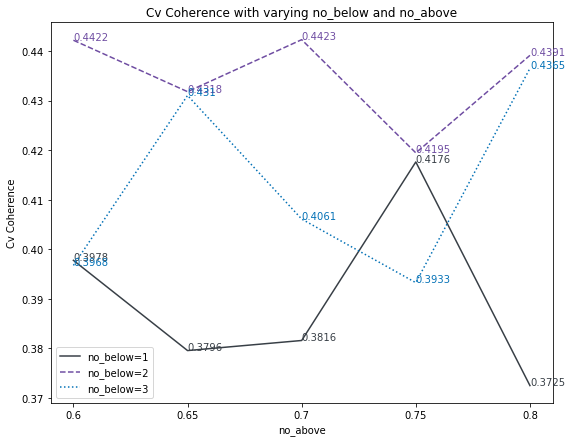

In [62]:
import matplotlib.pyplot as plt
logging.getLogger("matplotlib").setLevel(logging.ERROR)

# Visualize the results

target = str(Path("../data/LDA/final/hyperparams").resolve())
if not os.path.exists(target):
    os.makedirs(target)

no_above = [.6, .65, .7, .75, .8]
no_below = [1, 2, 3]
linewidth = 1.5
xlocs = range(len(no_above))

colors = [(56, 63, 70), (111, 77, 162), (3, 113, 182)]
colors = [(r/255,g/255,b/255) for (r,g,b) in colors]
linestyles = ["solid", "dashed", "dotted"]

plt.clf()
plt.figure(figsize=(9,7))
plt.title("Cv Coherence with varying no_below and no_above")
plt.xlabel("no_above") 
plt.ylabel("Cv Coherence")
for i in range(len(no_below)):
    vals = all_coherence[i]
    plt.plot([str(na) for na in no_above], vals, linewidth=linewidth, label="no_below="+str(no_below[i]), 
             color=colors[i], linestyle=linestyles[i])
    for x, y in enumerate([round(c, 4) for c in vals]):
        plt.text(str(no_above[x]), y, str(y),color=colors[i]) 
        
plt.legend(loc="best")
plt.savefig(Path(target,"no-above_no-below"))
plt.show()

In [7]:
num_articles = 3
num_words = 7

# Load the best of each no_below
models = [(6, 1, .75), (6, 2, .7), (6, 3, 0.8)]
for model in models:
    print("Topics for num_topics={}; no_below={}; no_above={}".format(model[0], model[1], model[2]), end=" ")
    lda_model = LdaModel.load(str(Path(target, "_".join([str(model[0]), str(model[1]), str(model[2])]) + ".gensim")))

    dictionary = TopicModeler.create_dictionary(corpus, no_below=model[1], no_above=model[2])
    bow_corpus = TopicModeler.create_bow(corpus, dictionary)
    
    topic_probs = {i: [] for i in range(model[0])}
    top_articles = []
    for doc_id, doc in zip(corpus_keys, corpus):
        topic_distribution = lda_model[lda_model.id2word.doc2bow(doc)]
        for topic_id, probability in topic_distribution:
            topic_probs[topic_id].append((doc_id, probability))
    for topic_id, doc_probs in topic_probs.items():
        doc_probs = sorted(doc_probs, key = lambda x: x[1], reverse = True)
        top_articles.append([prob for prob in doc_probs[:num_articles]]) 
        
    TopicModeler.print_topics(lda_model, num_words=num_words, top_articles=top_articles)
    
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary, sort_topics=False)
    pyLDAvis.save_html(vis, str(Path(target, "_".join([str(model[0]), str(model[1]), str(model[2])]) + ".html")))
    print("-"*50, "\nVisualization for topics:")
    display(pyLDAvis.display(vis))

Topics for num_topics=6; no_below=1; no_above=0.75 

,Topic #,Top keywords,Most related articles
0,1,"просодический, незавершенность, интонационный, фонетический, акцентоноситель, слог, тон","[2006_фонетико-акустическа - 38.44], [2007_алгоритмы-синтеза-пр - 35.82], [2008_интоколонатор-компью - 35.70]"
1,2,"проступок, речевать, преобразиться, преподавание иностранный язык, приводить к то что студент, ошибкология, согласований времен",
2,3,"выражать, событие, действие, состояние, устный, реплика, собеседник","[2014_vchera-nasochinyalsy - 88.93], [2019_some-features-of-the - 82.01], [2004_анекдоты-о-животных- - 78.54]"
3,4,"единица, семантический, отрицание, возможный, сочетание, интерпретация, семантика","[2000_автоматический-морфо - 74.89], [2007_дистрибуция-русских- - 69.43], [2000_восстанавливаемость- - 69.20]"
4,5,"метод, частота, количество, запрос, строка, выборка, ошибка","[2016_алгоритм-активного-о - 59.41], [2016_статистическая-обраб - 57.40], [2010_обучение-классификат - 56.93]"
5,6,"информация, разметка, задача, статья, основа, различный, возможность","[2000_semp-l-программная-с - 96.97], [2006_подход-к-построению- - 92.02], [2000_алгоритмы-cегментаци - 90.18]"


Topics for num_topics=6; no_below=2; no_above=0.7 

,Topic #,Top keywords,Most related articles
0,1,"разметка, статья, признак, связь, структура, описание, правило","[2000_алгоритмы-cегментаци - 87.77], [2002_семантический-поиск- - 77.02], [2000_автоматизация-технич - 73.78]"
1,2,"выражать, семантика, событие, отрицание, действие, сочетание, состояние","[2001_обозначение-симптомо - 65.39], [2009_прилагательные-со-зн - 62.12], [2001_лексика-со-значением - 61.27]"
2,3,"дискурсивный, вводный, век, реплика, указывать, коммуникация, дискурс","[2005_русский-анекдот-в-дв - 70.43], [2001_политический-анекдот - 68.67], [2008_мы-или-другие-имитац - 67.38]"
3,4,"оценка, показывать, оказываться, число, количество, вариант, встречаться","[2005_интонация-как-выраже - 70.67], [2000_вариант-системы-расп - 68.21], [2005_разрешение-синтаксич - 67.97]"
4,5,"синтаксический, интерпретация, предикат, коннектор, клауза, петя, именной","[2002_употребление-возврат - 48.67], [2006_рекурсивность-и-прое - 46.93], [2007_идентификация-поссес - 46.68]"
5,6,"метод, задача, поиск, запрос, использование, алгоритм, ресурс","[2000_автоматическая-систе - 58.90], [2000_semp-l-программная-с - 58.22], [2013_классификация-отзыво - 57.72]"


Topics for num_topics=6; no_below=3; no_above=0.8 

,Topic #,Top keywords,Most related articles
0,1,"результат, разметка, задача, метод, позволять, качество, использование","[2000_abbyy-retrieval-morp - 79.55], [2005_эффективный-алгоритм - 79.37], [2000_автоматизация-технич - 79.00]"
1,2,"реплика, коммуникация, дискурсивный, акт, адресат, дискурс, походка","[2019_some-features-of-the - 58.80], [2006_об-ушедшем-языковом- - 58.51], [2001_политический-анекдот - 58.19]"
2,3,"запись, просодический, акцент, незавершенность, фонетический, интонационный, пример","[2008_интоколонатор-компью - 50.61], [2007_алгоритмы-синтеза-пр - 48.59], [2006_фонетико-акустическа - 43.50]"
3,4,"пример, значение, тип, семантика, событие, выражать, предикат","[2007_идентификация-поссес - 50.95], [2002_употребление-возврат - 50.80], [2015_глаголы-быть-и-быват - 50.35]"
4,5,"класс, структура, семантический, описание, признак, элемент, описывать","[2000_semp-l-программная-с - 69.12], [2002_введение-в-теорию-по - 65.35], [2008_предметная-онтология - 65.17]"
5,6,"значение, разный, пример, оказываться, статья, встречаться, отрицание","[2020_лингвоспецифичные-сл - 64.52], [2004_о-классификации-прос - 63.47], [2010_теория-и-реальность- - 63.23]"


In [ ]:
END

In [17]:
from helpers import get_file_names
from pathlib import Path
from topic_modeling import TopicModeler

import logging
import os
import pickle

num_topics = 6
no_above = .6
no_below = 1

num_articles = 5
num_words = 7
repetitions = 5

target = str(Path("../data/LDA/final").resolve())
if not os.path.exists(target):
    os.makedirs(target)

# Load the preprocessed corpus
year_range = range(2000, 2021)
input_dir = str(Path("../data/preprocessed").resolve())
corpus = []
corpus_keys = []
for year in year_range:
    input_file = Path(input_dir, str(year) + ".pickle")
    with open(input_file, "rb") as file:
        cur_corpus = pickle.load(file)
    for doc_id, doc in enumerate(cur_corpus):
        key = str(year) + "_" + str(doc_id)
        corpus.append(doc)
        corpus_keys.append(key)

dictionary = TopicModeler.create_dictionary(corpus, no_below=no_below, no_above=no_above)
bow_corpus = TopicModeler.create_bow(corpus, dictionary)

# Get the best model of some repetitions
best_coherence = -1
for i in range(repetitions):
    print("Repetition[{}/{}]".format(i+1, repetitions), end=" ")
    lda_model = TopicModeler.train_lda(bow_corpus, dictionary, num_topics=num_topics)
    cur_coherence = TopicModeler.get_coherence_cv(lda_model, corpus, dictionary)
    if (cur_coherence > best_coherence):
        best_coherence = cur_coherence
        lda_model.save(str(Path(target, "all.gensim")))
    print("Coherence = {} (best: {})".format(cur_coherence, best_coherence))

Repetition[1/5] Coherence = 0.36231806083032286 (best: 0.36231806083032286)
Repetition[2/5] Coherence = 0.36766068165565674 (best: 0.36766068165565674)
Repetition[3/5] Coherence = 0.33285112237335174 (best: 0.36766068165565674)
Repetition[4/5] Coherence = 0.3781906905382418 (best: 0.3781906905382418)
Repetition[5/5] Coherence = 0.36511653409718975 (best: 0.3781906905382418)


In [18]:
from gensim.models import LdaModel
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

# Load the best model
lda_model = LdaModel.load(str(Path(target, "all.gensim")))

topic_probs = {i: [] for i in range(num_topics)}
top_articles = []
for doc_id, doc in zip(corpus_keys, corpus):
    topic_distribution = lda_model[lda_model.id2word.doc2bow(doc)]
    for topic_id, probability in topic_distribution:
        topic_probs[topic_id].append((doc_id, probability))
for topic_id, doc_probs in topic_probs.items():
    doc_probs = sorted(doc_probs, key = lambda x: x[1], reverse = True)
    top_articles.append([prob for prob in doc_probs[:num_articles]]) 

print("-"*50, "\nTopics for entire dialog corpus:")
TopicModeler.print_topics(lda_model, num_words=num_words, top_articles=top_articles)

vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
display(pyLDAvis.display(vis))

-------------------------------------------------- 
Topics for entire dialog corpus:


,Topic #,Top keywords,Most related articles
0,1,"разметка, статья, метод, параметр, оценка, признак, класс","[2000_6 - 96.97], [2000_4 - 92.65], [2003_113 - 92.43], [2004_8 - 92.25], [2000_2 - 91.95]"
1,2,"диктор, пауза, просодический, строка, незавершенность, фонетический, запись","[2008_25 - 40.95], [2004_33 - 35.61], [2006_121 - 35.31], [2007_6 - 34.82], [2005_81 - 32.13]"
2,3,"отрицание, предикат, клауза, валентность, класс, семантический, выступать","[2019_21 - 67.22], [2014_0 - 56.39], [2016_2 - 56.07], [2020_8 - 51.35], [2017_6 - 49.20]"
3,4,"омонимам, омонимия в русский язык, неравнообъемный, обобщать правило, обобщять, ненастно, островкина",
4,5,"омонимам, омонимия в русский язык, неравнообъемный, обобщать правило, обобщять, ненастно, островкина",
5,6,"выражать, единица, отмечать, встречаться, указывать, подобный, предполагать","[2000_8 - 94.45], [2005_44 - 87.31], [2006_44 - 86.92], [2002_136 - 85.22], [2004_49 - 84.60]"


c:\users\whyve\appdata\local\programs\python\python37\lib\site-packages\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
c:\users\whyve\appdata\local\programs\python\python37\lib\site-packages\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


In [30]:
from helpers import get_file_names
from pathlib import Path
from topic_modeling import TopicModeler

import logging
import os
import pickle


num_topics = 7
no_above = [.65, .7, .75, .8]
no_below = [1, 2, 3, 5]
num_articles = 3
num_words = 7
target = str(Path("../data/LDA/final").resolve())

if not os.path.exists(target):
    os.makedirs(target)

# Load the preprocessed corpus
year_range = range(2000, 2021)
input_dir = str(Path("../data/preprocessed").resolve())
corpus = []
corpus_keys = []
for year in year_range:
    input_file = Path(input_dir, str(year) + ".pickle")
    with open(input_file, "rb") as file:
        cur_corpus = pickle.load(file)
    for doc_id, doc in enumerate(cur_corpus):
        key = str(year) + "_" + str(doc_id)
        corpus.append(doc)
        corpus_keys.append(key)
    
coherence_umass = []
coherence_cv = []
perplexity = []

for nb in no_below:
    cur_coherence_umass = []
    cur_coherence_cv = []
    cur_perplexity = []
    for na in no_above:
        dictionary = TopicModeler.create_dictionary(entire_corpus.values(), no_below=nb, no_above=na)
        bow_corpus = TopicModeler.create_bow(entire_corpus.values(), dictionary)
        lda_model = TopicModeler.train_lda(bow_corpus, dictionary, num_topics=num_topics)

        topic_probs = {i: [] for i in range(num_topics)}
        top_articles = []
        for doc_id, doc in entire_corpus.items():
            topic_distribution = lda_model[lda_model.id2word.doc2bow(doc)]
            for topic_id, probability in topic_distribution:
                topic_probs[topic_id].append((doc_id, probability))
        for topic_id, doc_probs in topic_probs.items():
            doc_probs = sorted(doc_probs, key = lambda x: x[1], reverse = True)
            top_articles.append([prob for prob in doc_probs[:num_articles]]) 

        cur_coherence_umass.append(TopicModeler.get_coherence_umass(lda_model, bow_corpus))
        cur_coherence_cv.append(TopicModeler.get_coherence_cv(lda_model, entire_corpus.values(), dictionary))
        cur_perplexity.append(TopicModeler.get_perplexity(lda_model, bow_corpus))

        print("-"*50, "\nTopics for no_below={} no_above={}:".format(nb, na))
        print("umass: {}; cv: {}; perplexity: {}".format(
            round(cur_coherence_umass[-1], 2), round(cur_coherence_cv[-1], 4), round(cur_perplexity[-1], 2)))
        TopicModeler.print_topics(lda_model, num_words=num_words, top_articles=top_articles)
    coherence_umass.append(cur_coherence_umass)
    coherence_cv.append(cur_coherence_cv)
    perplexity.append(cur_perplexity)

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

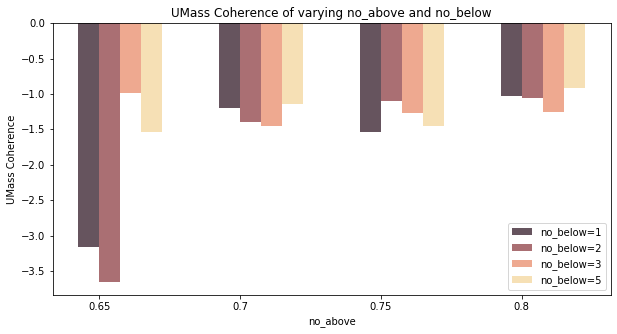

<Figure size 432x288 with 0 Axes>

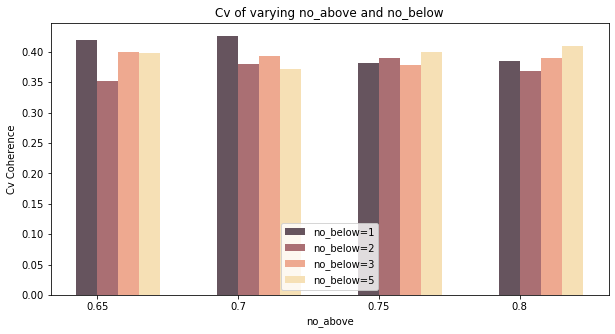

<Figure size 432x288 with 0 Axes>

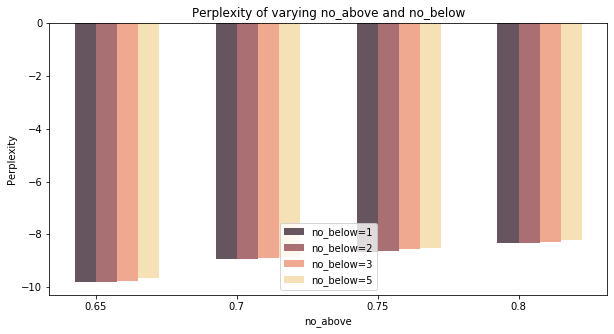

In [15]:
import matplotlib.pyplot as plt

# Visualize the results
width = 0.15
xlocs = range(len(no_above))
colors = [(102,84,94), (170,111,115), (238,169,144), (246,224,181)]
colors = [(r/255,g/255,b/255) for (r,g,b) in colors]

# Visualize the UMass Coherence
plt.clf()
plt.figure(figsize=(10,5))
plt.title("UMass Coherence of varying no_above and no_below")
plt.xlabel("no_above") 
plt.ylabel("UMass Coherence")

for i in xlocs:
    vals = [val[i] for val in coherence_umass]
    plt.bar([j + width*i for j in xlocs], vals, width, label="no_below=" + str(no_below[i]), 
            color = colors[i])
    
plt.xticks([j + width/2 for j in xlocs], no_above)
plt.legend(loc="best")
plt.savefig(Path(target, "umass_nbna.png"))
plt.show()

# Visualize the Cv Coherence
plt.clf()
plt.figure(figsize=(10,5))
plt.title("Cv of varying no_above and no_below")
plt.xlabel("no_above") 
plt.ylabel("Cv Coherence")

for i in xlocs:
    vals = [val[i] for val in coherence_cv]
    plt.bar([j + width*i for j in xlocs], vals, width, label="no_below=" + str(no_below[i]), 
            color = colors[i])
    
plt.xticks([j + width/2 for j in xlocs], no_above)
plt.legend(loc="best")
plt.savefig(Path(target, "cv_nbna.png"))
plt.show()

# Visualize the Perplexity
plt.clf()
plt.figure(figsize=(10,5))
plt.title("Perplexity of varying no_above and no_below")
plt.xlabel("no_above") 
plt.ylabel("Perplexity")

for i in xlocs:
    vals = [val[i] for val in perplexity]
    plt.bar([j + width*i for j in xlocs], vals, width, label="no_below=" + str(no_below[i]), 
            color = colors[i])
    
plt.xticks([j + width/2 for j in xlocs], no_above)
plt.legend(loc="best")
plt.savefig(Path(target, "perplexity_nbna.png"))
plt.show()

## Calculate the similiarity/divergence between papers for each year

<Figure size 432x288 with 0 Axes>

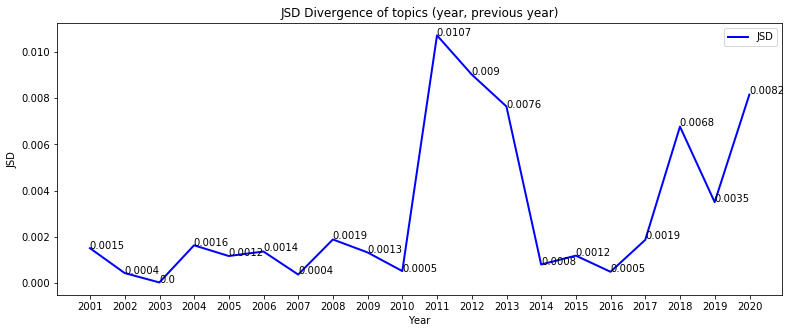

<Figure size 432x288 with 0 Axes>

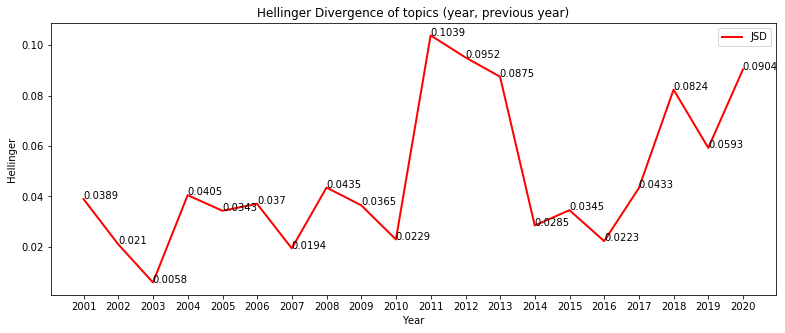

In [17]:
from gensim.matutils import jensen_shannon, hellinger
from gensim.models import LdaModel
from pathlib import Path

import matplotlib.pyplot as plt


year_range = range(2000, 2021)
model_dir = str(Path("../data/LDA/final").resolve())
input_dir = str(Path("../data/preprocessed").resolve())
target = str(Path("../data/LDA/final").resolve())

if not os.path.exists(target):
    os.makedirs(target)

lda_model = LdaModel.load(str(Path(model_dir, "all.gensim")))
distributions = []
divergence_hellinger = []
divergence_jsd = []

for year in year_range:
    cur_corpus = []
    input_file = Path(input_dir, str(year) + ".pickle")
    with open(input_file, "rb") as file:
        cur_corpus = pickle.load(file)
    cur_corpus = [token for sentence in cur_corpus for token in sentence]
    
    dist = [(t, 0) for t in range(1, num_topics+1)]
    for t, p in lda_model[lda_model.id2word.doc2bow(cur_corpus)]:
        dist[t] = (t, p)     
    distributions.append(dist)

# Divergence (year, previous year)
for i in range(1, len(year_range)):
    divergence_hellinger.append(hellinger(distributions[i], distributions[i-1]))
    divergence_jsd.append(jensen_shannon(distributions[i], distributions[i-1]))

# JSD Divergence
width = 0.01
xlocs = [i for i in year_range[1:]]

plt.clf()
plt.figure(figsize=(13,5))
plt.title("JSD Divergence of topics (year, previous year)")
plt.xlabel("Year") 
plt.ylabel("JSD")

for x, y in enumerate([round(c, 4) for c in divergence_jsd]):
    plt.text(xlocs[x] - width/2, y, str(y))
plt.xticks([num + width/2 for num in year_range[1:]],
           year_range[1:])

plt.plot(year_range[1:], divergence_jsd, color='blue', linewidth=2, label="JSD")
plt.legend(loc="best")
plt.savefig(Path(target,"divergence_jsd.png"))
plt.show()

# Hellinger divergence
plt.clf()
plt.figure(figsize=(13,5))
plt.title("Hellinger Divergence of topics (year, previous year)")
plt.xlabel("Year") 
plt.ylabel("Hellinger")

for x, y in enumerate([round(c, 4) for c in divergence_hellinger]):
    plt.text(xlocs[x] - width/2, y, str(y))
plt.xticks([num + width/2 for num in year_range[1:]],
           year_range[1:])

plt.plot(year_range[1:], divergence_hellinger, color='red', linewidth=2, label="JSD")
plt.legend(loc="best")
plt.savefig(Path(target,"divergence_hellinger.png"))
plt.show()

## Calculate the divergence between papers for from a year to previous years

<Figure size 432x288 with 0 Axes>

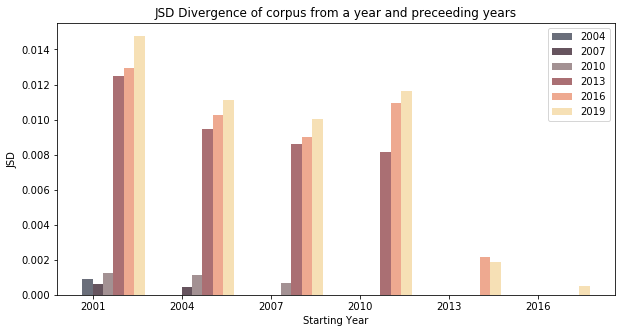

<Figure size 432x288 with 0 Axes>

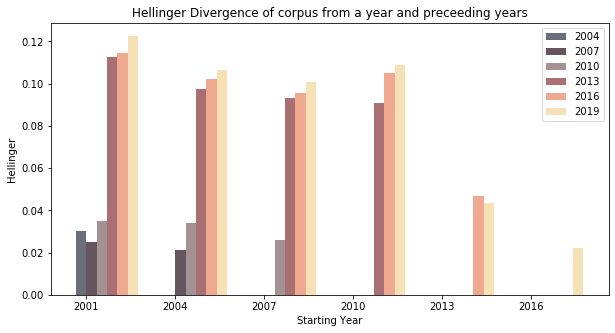

In [18]:
from gensim.matutils import jensen_shannon, hellinger
from gensim.models import LdaModel
from pathlib import Path

import matplotlib.pyplot as plt
import random


year_range = range(2001, 2021, 3)
model_dir = str(Path("../data/LDA/final").resolve())
input_dir = str(Path("../data/preprocessed").resolve())
target = str(Path("../data/LDA/final").resolve())

if not os.path.exists(target):
    os.makedirs(target)

lda_model = LdaModel.load(str(Path(model_dir, "all.gensim")))
distributions = []
colors = [(106,110,122), (102,84,94), (163,145,147), (170,111,115), (238,169,144), (246,224,181)]
colors = [(r/255,g/255,b/255) for (r,g,b) in colors]
divergence_hellinger = []
divergence_jsd = []

for year in year_range:
    cur_corpus = []
    input_file = Path(input_dir, str(year) + ".pickle")
    with open(input_file, "rb") as file:
        cur_corpus = pickle.load(file)
    cur_corpus = [token for sentence in cur_corpus for token in sentence]
    
    dist = [(t, 0) for t in range(1, num_topics+1)]
    for t, p in lda_model[lda_model.id2word.doc2bow(cur_corpus)]:
        dist[t] = (t, p)     
    distributions.append(dist)

# Divergence (year, previous year)
for i in range(0, len(year_range)-1):
    cur_div_hell = []
    cur_div_jsd = []
    for j in range(1, len(year_range)):
        if (i < j):
            cur_div_hell.append(hellinger(distributions[j], distributions[i]))
            cur_div_jsd.append(jensen_shannon(distributions[j], distributions[i]))
        else:
            cur_div_jsd.append(0)
            cur_div_hell.append(0)
    divergence_hellinger.append(cur_div_hell)
    divergence_jsd.append(cur_div_jsd)


# Print the JSD for a year and preceeding years
plt.clf()
plt.figure(figsize=(10,5))
plt.title("JSD Divergence of corpus from a year and preceeding years")
plt.xlabel("Starting Year") 
plt.ylabel("JSD")

width = 0.35
xlocs = [i for i in year_range[:-1]]
for i in range(0, len(year_range)-1):
    vals = [div[i] for div in divergence_jsd]
    plt.bar([year + width*i for year in year_range[:-1]], vals, width, label=str(year_range[i+1]), 
            color = colors[i])
    
plt.xticks([year + width/2 for year in year_range[:-1]], year_range[:-1])
plt.legend(loc="best")
plt.savefig(Path(target, "jsd_preceeding_years.png"))
plt.show()

# Print the hellinger for a year and preceeding years
plt.clf()
plt.figure(figsize=(10,5))
plt.title("Hellinger Divergence of corpus from a year and preceeding years")
plt.xlabel("Starting Year") 
plt.ylabel("Hellinger")

width = 0.35
xlocs = [i for i in year_range[:-1]]
for i in range(0, len(year_range)-1):
    vals = [div[i] for div in divergence_hellinger]
    plt.bar([year + width*i for year in year_range[:-1]], vals, width, label=str(year_range[i+1]), 
            color = colors[i])
    
plt.xticks([year + width/2 for year in year_range[:-1]], year_range[:-1])
plt.legend(loc="best")
plt.savefig(Path(target, "hellinger_preceeding_years.png"))
plt.show()

## Calculate the coherence and perplexity by year

Getting coherence & perplexity scores for 2000
Getting coherence & perplexity scores for 2001
Getting coherence & perplexity scores for 2002
Getting coherence & perplexity scores for 2003
Getting coherence & perplexity scores for 2004
Getting coherence & perplexity scores for 2005
Getting coherence & perplexity scores for 2006
Getting coherence & perplexity scores for 2007
Getting coherence & perplexity scores for 2008
Getting coherence & perplexity scores for 2009
Getting coherence & perplexity scores for 2010
Getting coherence & perplexity scores for 2011
Getting coherence & perplexity scores for 2012
Getting coherence & perplexity scores for 2013
Getting coherence & perplexity scores for 2014
Getting coherence & perplexity scores for 2015
Getting coherence & perplexity scores for 2016
Getting coherence & perplexity scores for 2017
Getting coherence & perplexity scores for 2018
Getting coherence & perplexity scores for 2019
Getting coherence & perplexity scores for 2020


<Figure size 432x288 with 0 Axes>

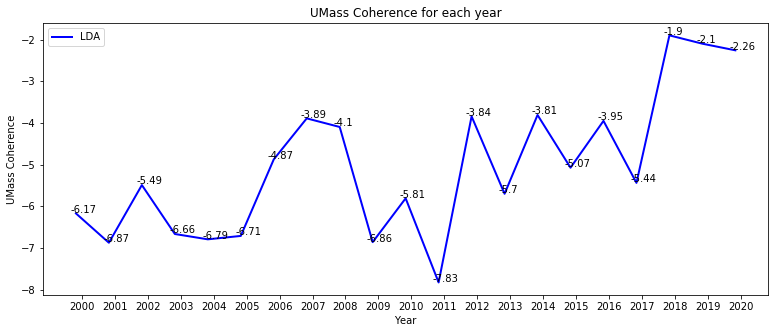

<Figure size 432x288 with 0 Axes>

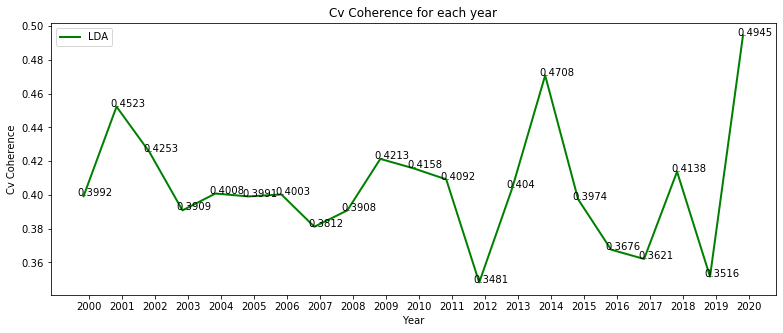

<Figure size 432x288 with 0 Axes>

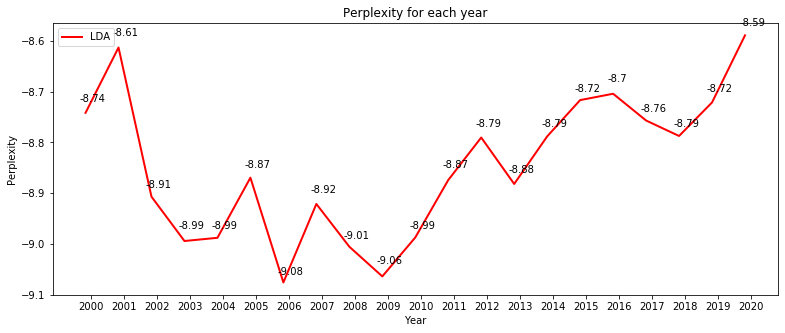

In [10]:
from gensim.models import LdaModel
from gensim.test.utils import datapath
from pathlib import Path

import matplotlib.pyplot as plt


num_topics = 6
no_above = .75
no_below = 1

year_range = range(2000, 2021)
model_dir = str(Path("../data/LDA/final").resolve())
input_dir = str(Path("../data/preprocessed").resolve())
target = str(Path("../data/LDA/final").resolve())

if not os.path.exists(target):
    os.makedirs(target)

coherence_umass = []
coherence_cv = []
perplexity = []

target = str(target)
if not os.path.exists(target):
    os.makedirs(target)

for year in year_range:
    print("Getting coherence & perplexity scores for", year)
    cur_corpus = []
    input_file = Path(input_dir, str(year) + ".pickle")
    with open(input_file, "rb") as file:
        cur_corpus = pickle.load(file)
    
    dictionary = TopicModeler.create_dictionary(cur_corpus, no_below=no_below, no_above=no_above)
    bow_corpus = TopicModeler.create_bow(cur_corpus, dictionary)
    lda_model = LdaModel.load(str(Path(model_dir, str(year) + ".gensim")))
    
    coherence_umass.append(TopicModeler.get_coherence_umass(lda_model, bow_corpus))
    coherence_cv.append(TopicModeler.get_coherence_cv(lda_model, cur_corpus, dictionary))
    perplexity.append(TopicModeler.get_perplexity(lda_model, bow_corpus))

    
# Visualize the results
width = 0.35
xlocs = [i for i in year_range]

## Coherence UMass
plt.clf()
plt.figure(figsize=(13,5))
plt.title("UMass Coherence for each year")
plt.xlabel("Year") 
plt.ylabel("UMass Coherence")

for x, y in enumerate([round(c, 2) for c in coherence_umass]):
    plt.text(xlocs[x] - width/2, y + .02, str(y))
plt.xticks([num + width/2 for num in year_range],
           year_range)

plt.plot(year_range, coherence_umass, color='blue', linewidth=2, label="LDA")
plt.legend(loc="best")
plt.savefig(Path(target,"years-coherence_umass.png"))
plt.show()

## Coherence Cv
plt.clf()
plt.figure(figsize=(13,5))
plt.title("Cv Coherence for each year")
plt.xlabel("Year") 
plt.ylabel("Cv Coherence")

for x, y in enumerate([round(c, 4) for c in coherence_cv]):
    plt.text(xlocs[x] - width/2, y, str(y))
plt.xticks([num + width/2 for num in year_range],
           year_range)

plt.plot(year_range, coherence_cv, color='green', linewidth=2, label="LDA")
plt.legend(loc="best")
plt.savefig(Path(target,"years-coherence_cv.png"))
plt.show()

## Perplexity
plt.clf()
plt.figure(figsize=(13,5))
plt.title("Perplexity for each year")
plt.xlabel("Year") 
plt.ylabel("Perplexity")

for x, y in enumerate([round(p, 2) for p in perplexity]):
    plt.text(xlocs[x] - width/2, y + .02, str(y))
plt.xticks([num + width/2 for num in year_range],
           year_range)

plt.plot(year_range, perplexity, color='red', linewidth=2, label="LDA")
plt.legend(loc="best")
plt.savefig(Path(target, "years-perplexity.png"))
plt.show()